## Copernicus Seasonal Forecast Module

This module is developed to manage seasonal forecast data from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu) (CDS) for the [U-CLIMADAPT project](https://www.copernicus-user-uptake.eu/user-uptake/details/responding-to-the-impact-of-climate-change-u-climadapt-488). 
It offers comprehensive tools for downloading, processing, computing climate indices, and generating hazard objects based on seasonal forecast datasets, particularly [Seasonal forecast daily and subdaily data on single levels](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview). 
The module is tailored to integrate seamlessly with the [CLIMADA](https://climada.ethz.ch/)(CLIMate ADAptation) platform, supporting climate risk assessment and the development of effective adaptation strategies.

Features:
- Download seasonal forecast data from CDS
- Process raw data into climate indices
- Calculate various heat-related indices (e.g., Maximum Temperature, Tropical Nights)
- Create CLIMADA Hazard objects for further risk analysis
- Visualize hazard data

Prerequisites:

1. CDS account and API key:
   Register at https://cds.climate.copernicus.eu

2. CDS API client installation:
   pip install cdsapi

3. CDS API configuration:
   Create a .cdsapirc file in your home directory with your API key and URL.
   For instructions, visit: https://cds.climate.copernicus.eu/how-to-api#install-the-cds-api-client

4. Dataset Terms and Conditions: After selecting the dataset to download, make 
   sure to accept the terms and conditions on the corresponding dataset webpage in the CDS portal before running this notebook. Here, https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download.

Usage:
This module is typically imported and used within larger scripts or applications for climate data processing
and risk assessment. See individual function docstrings for specific usage instructions.

Note:
Ensure you have the necessary permissions and comply with the CDS data usage policies when using this module. You can view the terms and conditions at https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download. You can find them at the bottom of the download page.

In [1]:
# Import packages

import warnings
import datetime as dt
warnings.filterwarnings('ignore')

from climada.hazard import Hazard
from climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard import SeasonalForecast, month_name_to_number

# these functions could also be imported from climada_python in the future
from climada_petals.hazard.copernicus_interface.temporary_bounding_box_functions import (
    bounding_box_from_cardinal_bounds, bounding_box_global, bounding_box_from_countries
    )


### Set up module parameters

To configure the module for working with Copernicus forecast data and converting it into a hazard object for CLIMADA, you will need to define several essential parameters. These settings are crucial as they specify the type of data to be retrieved, the data format, the forecast period, and the geographical area of interest. These parameters influence how the forecast data is processed and transformed into a hazard object.

Below, we outline these parameters and use an example for the "Maximum Temperature" index to demonstrate the seasonal forecast functionality.

To learn more about what these parameters entail and their significance, please refer to the [documentation on the CDS webpage](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview).

#### Overview of parameters

**index_metric**: Defines the type of index to be calculated. The current options available are 'HIA' (Heat Index Adjusted), 'HIS' (Heat Index Simplified), 'Tmean' (Mean Temperature), 'Tmin' (Minimum Temperature), 'Tmax' (Maximum Temperature), 'HW' (Heat Wave), 'TR' (Tropical Nights), 'TX30' (Hot Days), 'HUM' (Humidex), 'RH' (Relative Humidity), 'AT' (Apparent Temperature), and 'WBGT' (Wet Bulb Globe Temperature (Simple)).

  - **Heat Waves ("HW")**:  
    If `index_metric` is set to 'HW' for heat wave calculations, additional parameters can be specified to fine-tune the heat wave detection:

    - **threshold**: Temperature threshold above which days are considered part of a heat wave. Default is 27°C.
    - **min_duration**: Minimum number of consecutive days above the threshold required to define a heat wave event. Default is 3 days.
    - **max_gap**: Maximum allowable gap (in days) between two heat wave events to consider them as one single event. Default is 0 days.

  - **Tropical Nights ("TR")**:  
    If `index_metric` is set to 'TR' for tropical nights, an additional parameter can be specified to set the threshold:

    - **threshold**: Nighttime temperature threshold, above which a night is considered "tropical." Default is 20°C.



**data_format** : Specifies the format of the data to be downloaded, "grib" or "netcdf". Copernicus do **NOT** recommended netcdf format for operational workflows since conversion to netcdf is considered experimental. [More information here](https://confluence.ecmwf.int/display/CKB/GRIB+to+netCDF+conversion+on+new+CDS+and+ADS+systems).

**originating_centre**: Identifies the source of the data. A standard choice is "dwd" (German Weather Service), one of eight providers including ECMWF, UK Met Office, Météo France, CMCC, NCEP, JMA, and ECCC.

**system**: Refers to a specific model or configuration used for forecasts. In this script, the default value is "21," which corresponds to the GCSF (German Climate Forecast System) [version 2.1](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002101). More details can be found in the [CDS documentation](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=documentation).

**year_list**: A list of years for which data should be downloaded and processed.

**initiation_month**: A list of the months in which the forecasts are initiated. Example: ["March", "April"]. 

**forecast_period**: Specifies the months relative to the forecast's initiation month for which the data is forecasted. Example: ["June", "July", "August"] indicates forecasts for these months. The maximum available is 7 months.

  - **⚠️ Important**: When an initiation month is in one year and the forecast period in the next, the system recognizes the forecast extends beyond the initial year. Data is retrieved based on the initiation month, with lead times covering the following year. The forecast is stored under the initiation year’s directory, ensuring consistency while spanning both years.

**area_selection**: This determines the geographical area for which the data should be downloaded. It can be set to
- "global" (gobal data is downloaded)
- a list of four numbers corresponding to the geographical bounds (in degrees; EPSG:4326), specified as [north, west, south, east]. 
- a list of ISO alpha-3 codes for different countries, e.g., ["DEU", "CHE"] for Germany and Switzerland. See this [wikipedia page](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for the country codes. Note that the **joint region** will be downloaded and processed, i.e., handling data for ["DEU", "CHE"] and then for ["CHE"] will download and generate two sets of data.

**overwrite**: Boolean flag that, when set to True, forces the system to redownload and reprocess existing files.


In [2]:
# We define above parameters for an example 
index_metric = "TX30" 
data_format = "grib"  # 'grib' or 'netcdf'
originating_centre =  "dwd"
system =  "21" 
forecast_period = ["Jun", "August"] # from jun to august including july
year_list = [2023]
initiation_month = [ "March","April","May"]  
overwrite = False

# global bounding box
# bounds = bounding_box_global()
# input cardinal bounds
# bounds = bounding_box_from_cardinal_bounds(northern=49, eastern=20, southern=40, western=10)
# input country ISO codes
bounds = bounding_box_from_countries(["CHE"])

# Parameters for Heat Waves 
hw_threshold = 27
hw_min_duration = 3
hw_max_gap = 0

# Parameters for Tropical Nights 
threshold_tr = 20

# Describe the selected climate index and the associated input data
handler = SeasonalForecast(
    index_metric=index_metric,
    year_list=year_list,
    forecast_period=forecast_period,
    initiation_month=initiation_month,
    bounds=bounds,
    data_format=data_format,
    originating_centre=originating_centre,
    system=system,
    )

handler.explain_index()

'Explanation for TX30: Hot Days (TX30): Counts days with maximum temperature exceeding 30°C. \nRequired variables: 2m_temperature'

### Download and Process Data

The `handler.download_and_process_data` method in CLIMADA efficiently retrieves and organizes Copernicus forecast data. It checks for existing files to avoid redundant downloads, stores data by format (grib or netCDF), year, month. Then the files are processed for further analysis, such as calculating climate indices or creating hazard objects within CLIMADA. Here are the aspects of this process:

- **Data Download**: The method downloads the forecast data for the selected years, months, and regions. The data is retrieved in **grib** or **netCDF** formats, which are commonly used for storing meteorological data. If the required files already exist in the specified directories, the system will skip downloading them, as indicated by the log messages such as:  
  *"Corresponding grib file SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib already exists."* 


- **Data Processing**: After downloading (or confirming the existence of) the files, the system converts them into daily **netCDF** files. This format suseful for working with multi-dimensional climate data. The log messages confirm the existence or creation of these files, for example:  
  *"Daily file SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/processed_data/TX30_boundsW4_S44_E11_N48.nc already exists."*

- **Geographic and Temporal Focus**: The files are generated for a specific time frame (e.g., June and July 2022) and a predefined geographic region, as specified by the parameters such as `bounds`, `month_list`, and `year_list`. This ensures that only the selected data for your analysis is downloaded and processed.

- **Data Completeness**: Messages like "already exists" ensure that you do not redundantly download or process data, saving time and computing resources. However, if the data files are missing, they will be downloaded and processed as necessary.

In [3]:
# Download and process data
handler.download_and_process_data()

2025-03-24 15:25:45,339 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib already exists.
2025-03-24 15:25:45,339 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib already exists.
2025-03-24 15:25:45,340 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init05/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib already exists.
2025-03-24 15:25:45,340 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21

{'downloaded_data': {'2023_init03_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib'),
  '2023_init04_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib'),
  '2023_init05_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init05/valid06_08/downloaded_data/grib/TX30_boundsW4_S44_E11_N48.grib')},
 'processed_data': {'2023_init03_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/processed_data/TX30_boundsW4_S44_E11_N48.nc'),
  '2023_init04_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/processed_data/TX30_boundsW4_S44_E11_N48.nc'),
  '2023_init05_valid06_08': Posix

### Calculate Climate Indices

When you use the `handler.calculate_index` method in CLIMADA to compute specific climate indices (such as Maximum Temperature), the generated output is saved and organized in a structured format for further analysis. Here some details:

- **Index Calculation**: The method processes seasonal forecast data to compute the selected index for the chosen years, months, and regions. This index represents a specific climate condition, such as the number of Maximum Temperature ("Tmax") over the forecast period, as defined in the parameters.

- **Data Storage**: The calculated index data is saved in **netCDF** format. These files are automatically saved in directories specific to the index and time period. The file paths are printed below the processing steps. For example, the computed index values are stored in:  
  *"SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_daily.nc"*. 

  Similarly, the statistics of the index (e.g., mean, max, min, std) are saved in:  
  *"SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_stats.nc"*. 
  These files ensure that both the raw indices and their statistical summaries are available for detailed analysis.
  
  Each file contains data for a specific month and geographic region, as defined in the parameters. This allows you to analyze how the selected climate index varies over time and across different locations.

- **Completeness of Data Processing**: Messages 'Index Tmax successfully calculated and saved for...' confirm the successful calculation and storage of the index, ensuring that all requested data has been processed and saved correctly.


In [4]:
# Calculate index
handler.calculate_index(hw_threshold=hw_threshold, hw_min_duration=hw_min_duration, hw_max_gap=hw_max_gap)

2025-03-24 15:25:45,346 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - Processing index TX30 for year 2023, initiation month 03.
2025-03-24 15:25:45,347 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - A file of ['/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_daily.nc', '/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_monthly.nc', '/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_stats.nc'] already exists.
2025-03-24 15:25:45,348 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - Processing index TX30 for year 2023, initiation month 04.
2025-03-24 15:25:45,349 - climada_petals.hazard.copernicus_interface.create_seasonal_fo

{'2023_init03_valid06_08': {'daily': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_daily.nc'),
  'monthly': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_monthly.nc'),
  'stats': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_stats.nc')},
 '2023_init04_valid06_08': {'daily': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_daily.nc'),
  'monthly': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_monthly.nc'),
  'stats': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/

### Calculate a Hazard Object

When you use the `handler.process_and_save_hazards` method in CLIMADA to convert processed index from Copernicus forecast data into a hazard object:

- **Hazard Object Creation**: The method processes seasonal forecast data for specified years and months, converting these into hazard objects. These objects encapsulate potential risks associated with specific weather events or conditions, such as Maximum Temperature ('Tmax') indicated in the parameters, over the forecast period.

- **Data Storage**: The hazard data for each ensemble member of the forecast is saved as HDF5 files. These files are automatically stored in specific directories corresponding to each month and type of hazard. The file paths are printed below the processing steps. For example, *"/SYSTEM_DIR/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5"*.
 HDF5 is a versatile data model that efficiently stores large volumes of complex data.
 
 Each file is specific to a particular month and hazard scenario ('Tmax' in this case) and covers all ensemble members for that forecast period, aiding in detailed risk analysis.

- **Completeness of Data Processing**: Messages like 'Completed processing for 2022-07. Data saved in...' confirm the successful processing and storage of the hazard data for that period, ensuring that all requested data has been properly handled and stored.

#### Visualizing the Calculated Hazard Object

Once the hazard object has been successfully calculated, the last element created is printed for visualization. This is important for several reasons:

- **Initial Data Inspection**: The visualization allows you to view a slice of the forecast data, providing a quick check of the results. This initial glimpse helps you verify that the data processing was successful and provides insights into the distribution of the hazard (in this case, Maximum Temperature) across the area of interest.

- **Geographic Accuracy**: The map helps you verify if the correct geographic region was processed and plotted. This is particularly useful as it allows immediate feedback on whether the user-defined boundaries or selected areas (e.g., Germany and Switzerland) were captured correctly.

- **Data Quality Check**: Visualizing the output also serves as a preliminary quality check, allowing you to detect any unexpected results or anomalies in the data. For instance, the color bar indicating the "Intensity (days)" gives an indication of how the hazard index is distributed across the mapped area.

- **Quick Workflow Testing**: This step is essential for testing the entire workflow, ensuring that the process is working as expected from data download, processing, and hazard object creation to visualization.

This output provides a structured dataset ready for further analysis within the CLIMADA framework, allowing for the evaluation of potential impacts and the planning of mitigation strategies. 


In [5]:
handler.save_index_to_hazard()

2025-03-24 15:25:45,354 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - Creating hazard for index TX30 for year 2023, initiation month 03.
2025-03-24 15:25:45,355 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5 already exists.
2025-03-24 15:25:45,356 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - Creating hazard for index TX30 for year 2023, initiation month 04.
2025-03-24 15:25:45,356 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5 already exists.
2025-03-24 15:25:45,357 - climada_petals.hazard.copernicus_interface.create_seasonal_forecast_hazard - INFO - Creating

{'2023_init03_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5'),
 '2023_init04_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5'),
 '2023_init05_valid06_08': PosixPath('/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init05/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5')}

## Example for reading and plotting hazard

The saved hazard file can then be read and processed by standard CLIMADA methods. For instance, below, we load the hazard for the last month and plot the intensity per grid point maximized over all forecast ensemble members.

2025-03-24 15:25:45,365 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5


Available Dates Across Members: ['2023-06-01', '2023-07-01', '2023-08-01']
Selected Date for Plotting: 2023-08-01


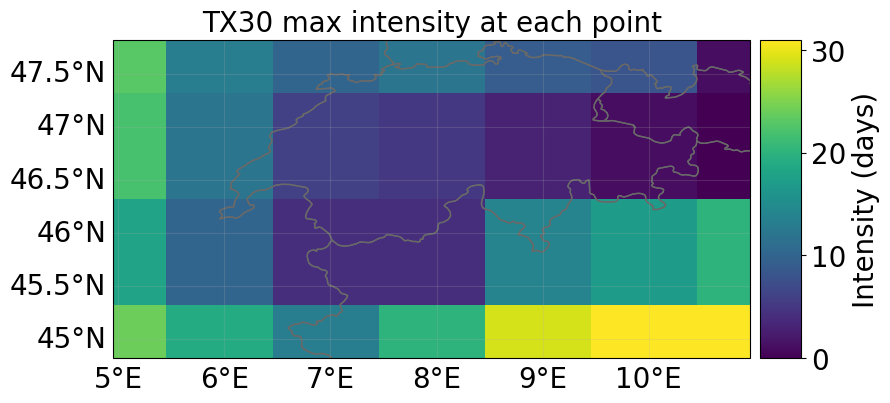

In [6]:
# load an example hazard
initiation_month_str = f"{month_name_to_number(initiation_month[0]):02d}"
forecast_month_str = f"{handler.valid_period_str[-2:]}"  # Last month in valid period
forecast_year =  year_list[0]
if int(initiation_month_str) > int(forecast_month_str):  
    forecast_year += 1  # Forecast extends to the next year

# Load the hazard and plot intensity for the selected grid, maximized over ensemble
path_to_hazard = handler.get_pipeline_path(forecast_year, initiation_month_str, "hazard")
haz = Hazard.from_hdf5(path_to_hazard)

if haz:
    available_dates = sorted(set(haz.date))  # Remove duplicates and sort
    readable_dates = [dt.datetime.fromordinal(d).strftime('%Y-%m-%d') for d in available_dates] # Convert ordinal dates to ISO 8601 date format (YYYY-MM-DD)
    print("Available Dates Across Members:", readable_dates)  # Print only unique dates

    # Find the closest date in the dataset
    target_date = dt.datetime(forecast_year, int(forecast_month_str), 1).toordinal()
    closest_date = min(available_dates, key=lambda x: abs(x - target_date))
    closest_date_str = dt.datetime.fromordinal(closest_date).strftime('%Y-%m-%d')

    # Plot intensity for the selected event 
    print(f"Selected Date for Plotting: {closest_date_str}")
    haz.select(date=[closest_date, closest_date]).plot_intensity(event=0, smooth=False)
else:
    print("No hazard data found for the selected period.")

## Finished with the Seasonal Forecast Module, Now Moving on to Analyzing the Collected Data

- indice
    - 1. Start analyzing the data calculated by the index
    - 2. We can now estimate the exposure
    - 3. Set up vulnerability and calculate potential damages

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from climada.entity import LitPop

# CLIMADA Petals: Copernicus interface utility functions
from climada_petals.hazard.copernicus_interface.utility_functions import (
    plot_forecast,
    plot_summary_statistics,
    plot_individual_and_aggregated_impacts,
    plot_impact_distributions,
    plot_statistics_per_location,
    plot_statistics_and_member_agreement,
    print_summary_statistics,
    plot_intensity_distributions,
    forecast_skills_metrics
)


#### 1. Start analyzing the data calculated by the index

Using monthly index file: /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_monthly.nc
Successfully loaded dataset: /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_monthly.nc


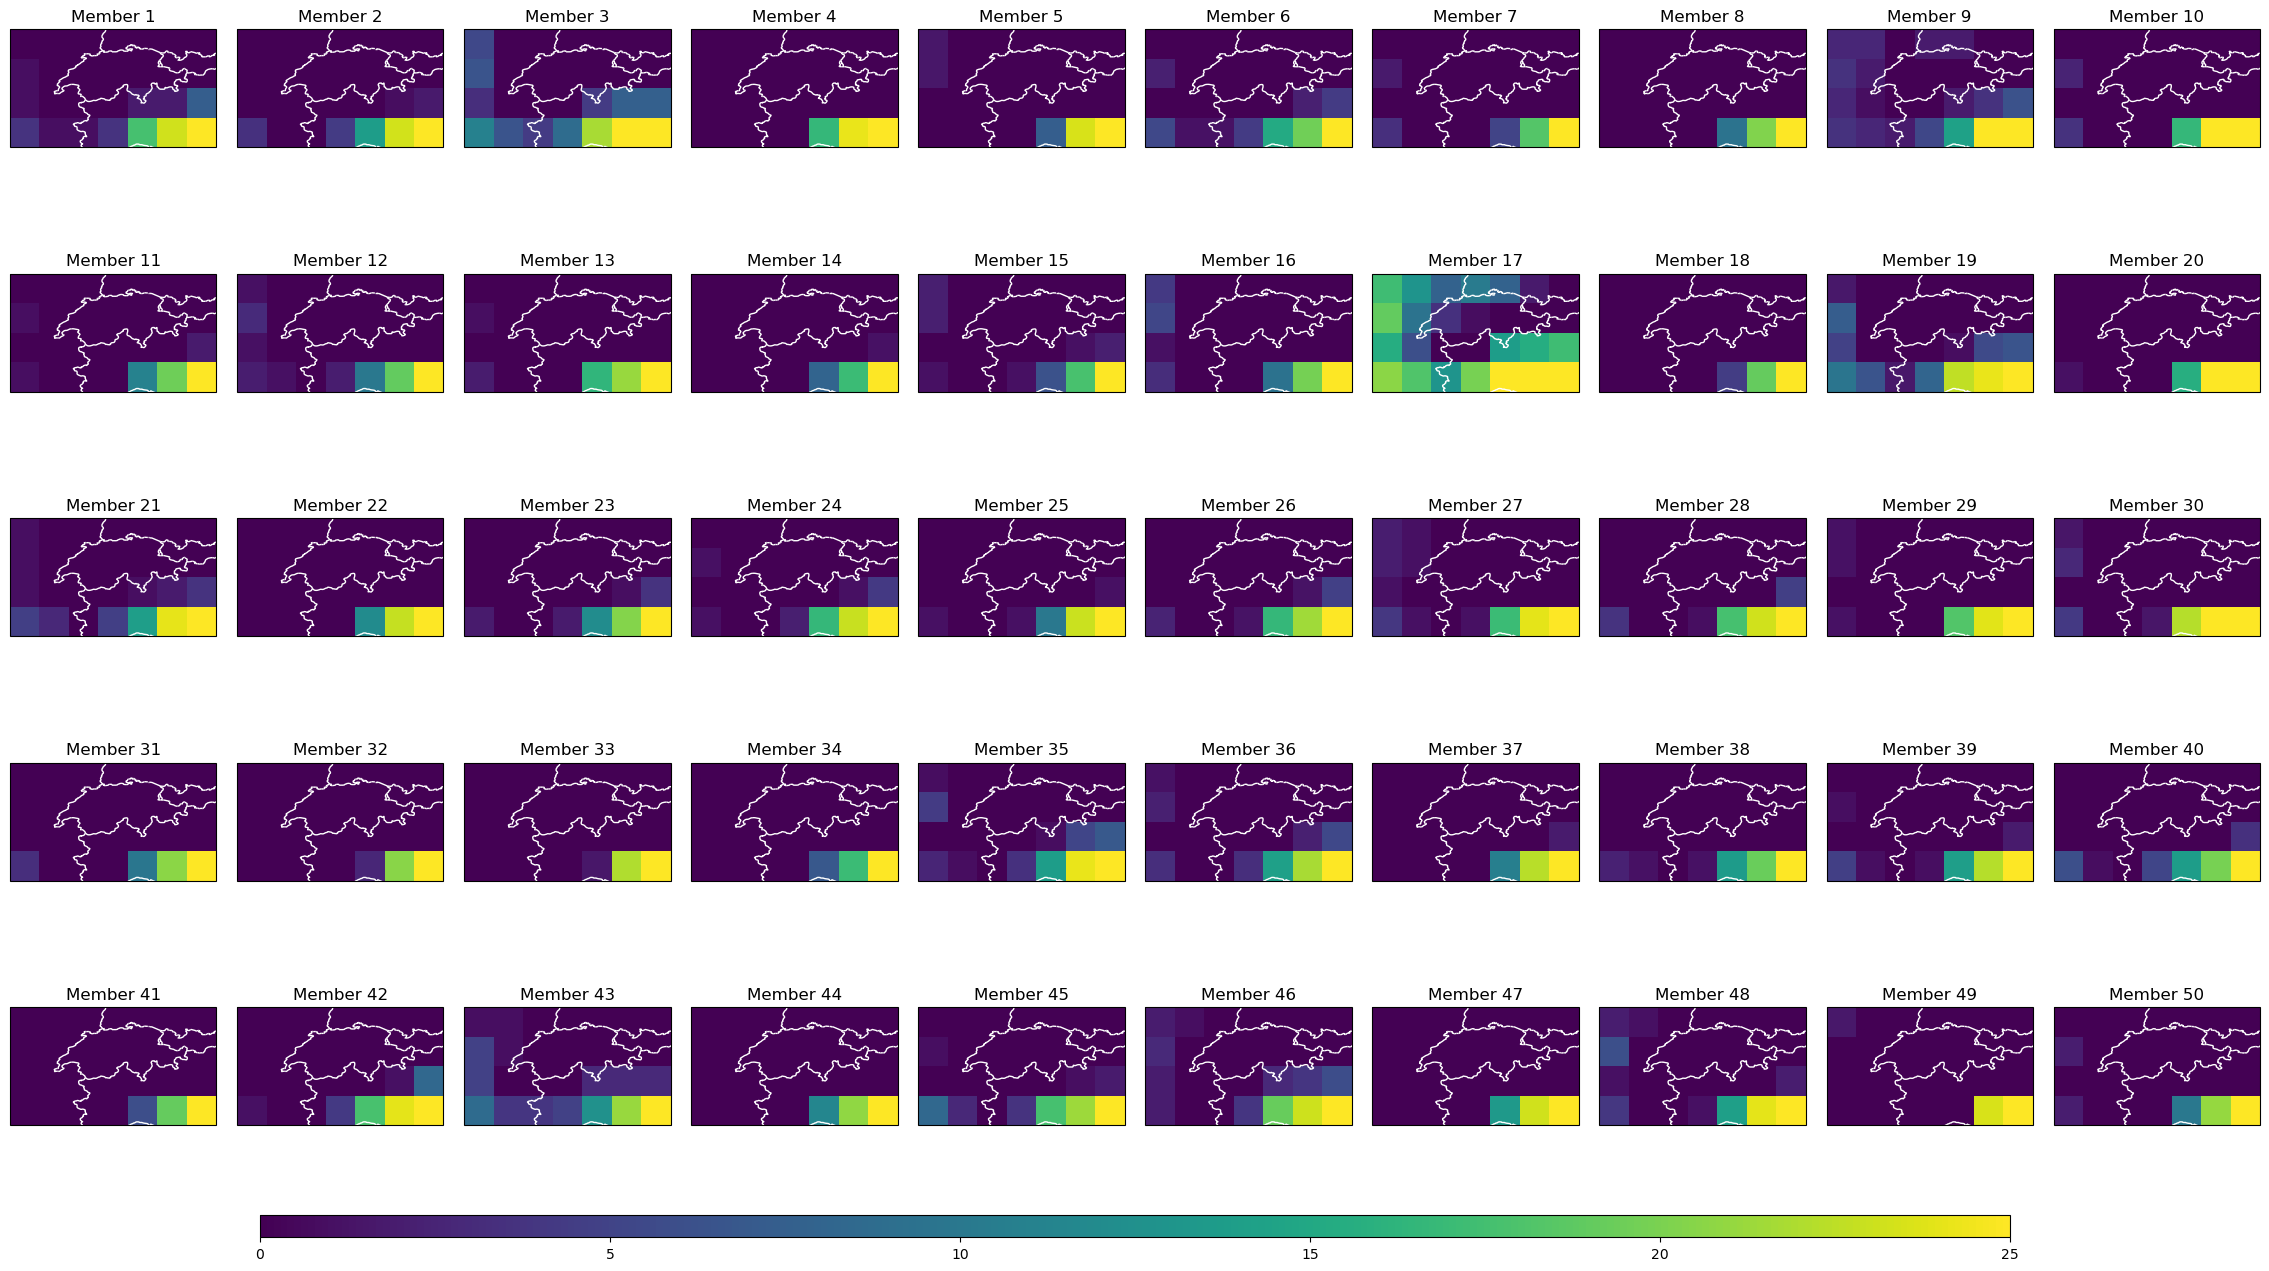

In [8]:
# Plot a sample of the index data
plot_forecast(2023, "03", "2023-07", handler)

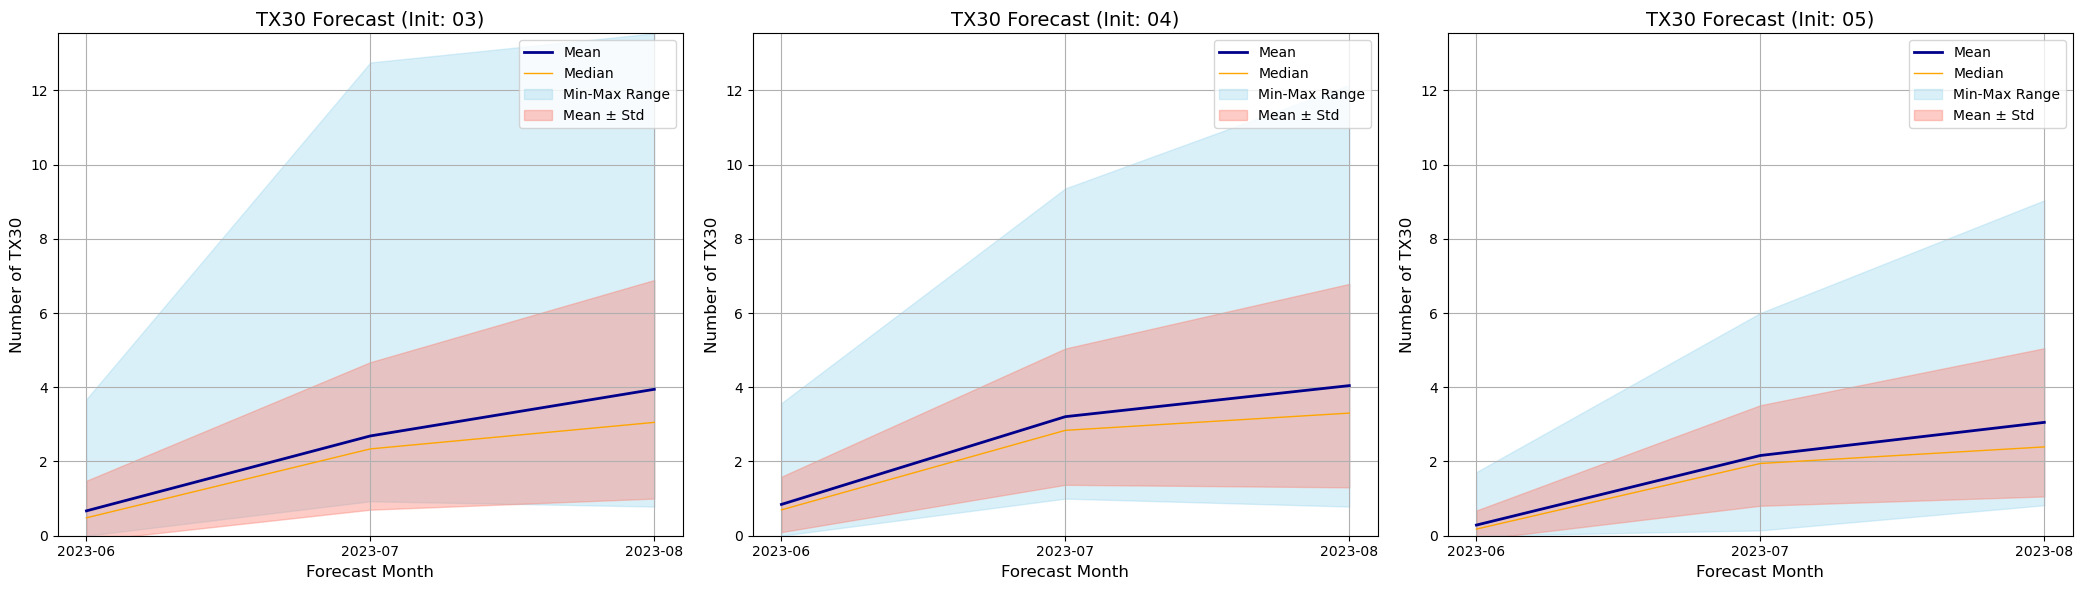

In [9]:
# forecast verification plots: 
# analyzing ensemble prediction system (EPS) behavior over time across members
plot_summary_statistics(
    forecast_year=2023, 
    initiation_months=["03","04", "05"], 
    valid_periods=["06", "07", "08"],
    handler=handler
)

In [10]:
hazard = Hazard.from_hdf5(path_to_hazard)
# Access hazard attributes
print("Hazard attributes:")
print(" - Shape of intensity (time, gridpoint):", hazard.intensity.shape)
print(" - Centroids:", hazard.centroids.shape)
print(" - Units:", hazard.units)
print(" - event_id:", hazard.event_id)
print(" - frequency:", hazard.frequency)
print(" - min, max fraction:", hazard.fraction.min(), hazard.fraction.max())
print(" - Date:", hazard.date)
print("min, max fraction: ", hazard.fraction.min(), hazard.fraction.max())
print(" - event_name:")
hazard.event_name

2025-03-24 15:25:50,655 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5
Hazard attributes:
 - Shape of intensity (time, gridpoint): (150, 28)
 - Centroids: (4, 7)
 - Units: days
 - event_id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150]
 - frequency: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

['member0',
 'member0',
 'member0',
 'member1',
 'member1',
 'member1',
 'member2',
 'member2',
 'member2',
 'member3',
 'member3',
 'member3',
 'member4',
 'member4',
 'member4',
 'member5',
 'member5',
 'member5',
 'member6',
 'member6',
 'member6',
 'member7',
 'member7',
 'member7',
 'member8',
 'member8',
 'member8',
 'member9',
 'member9',
 'member9',
 'member10',
 'member10',
 'member10',
 'member11',
 'member11',
 'member11',
 'member12',
 'member12',
 'member12',
 'member13',
 'member13',
 'member13',
 'member14',
 'member14',
 'member14',
 'member15',
 'member15',
 'member15',
 'member16',
 'member16',
 'member16',
 'member17',
 'member17',
 'member17',
 'member18',
 'member18',
 'member18',
 'member19',
 'member19',
 'member19',
 'member20',
 'member20',
 'member20',
 'member21',
 'member21',
 'member21',
 'member22',
 'member22',
 'member22',
 'member23',
 'member23',
 'member23',
 'member24',
 'member24',
 'member24',
 'member25',
 'member25',
 'member25',
 'member26',
 'm

We can also explore in CLIMADA the hazard's analytical tools, including an estimate of the return period. However, due to the limited number of events in the seasonal forecast dataset, **this does not represent a true return period**, but rather a demonstration of the methodology. For meteorological data, at least 30 years of data is typically required for this type of estimation.

2025-03-24 15:25:50,686 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5
2025-03-24 15:25:50,702 - climada.hazard.base - WARNING - Return period 25.0 exceeds max. event return period.
2025-03-24 15:25:50,704 - climada.hazard.base - WARNING - Return period 50.0 exceeds max. event return period.
2025-03-24 15:25:50,705 - climada.hazard.base - WARNING - Return period 100.0 exceeds max. event return period.
2025-03-24 15:25:50,706 - climada.hazard.base - WARNING - Return period 250.0 exceeds max. event return period.
2025-03-24 15:25:50,708 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [ 25  50 100 250]


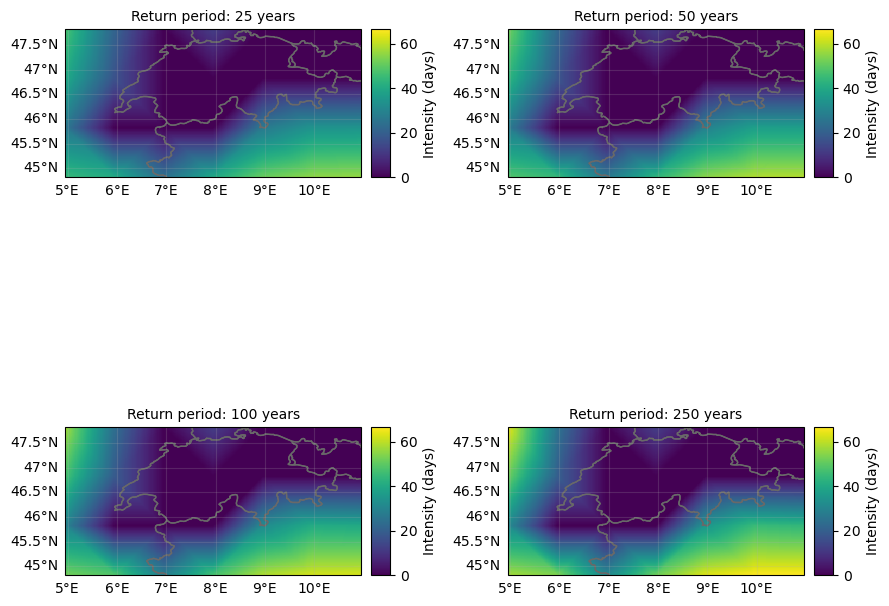

In [11]:
# Load the hazard and plot intensity for the selected grid, maximized over ensemble
path_to_hazard = handler.get_pipeline_path(forecast_year, initiation_month_str, "hazard")
hazard = Hazard.from_hdf5(path_to_hazard)
# Visualize return periods of different locations using the plot_rp_intensity() function
hazard.plot_rp_intensity(
    return_periods=(25, 50, 100, 250),
    smooth=True,
    axis=None,
    figsize=(9, 13),
    adapt_fontsize=True,
);

2025-03-24 15:25:56,867 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5
2025-03-24 15:25:56,884 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init04/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5
2025-03-24 15:25:56,899 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init05/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5

Initiation Month 03
  Max intensity: 31.00
  Min intensity: 0.00
  Mean: 3.94
  Median: 0.00
  Std Dev: 7.37

Initiation Month 04
  Max intensity: 31.00
  Min intensity: 0.00
  Mean: 4.04
  Median: 0.00
  Std Dev: 6.89

Initiation Month 05
  Max intensity: 31.00
  Min intensity: 0.00
  Mean: 3.05
  Median: 0.00
  Std Dev: 6.54
2025-03-24 15:25:56,923 - climada.hazard.io - INFO - Reading /Users/daray

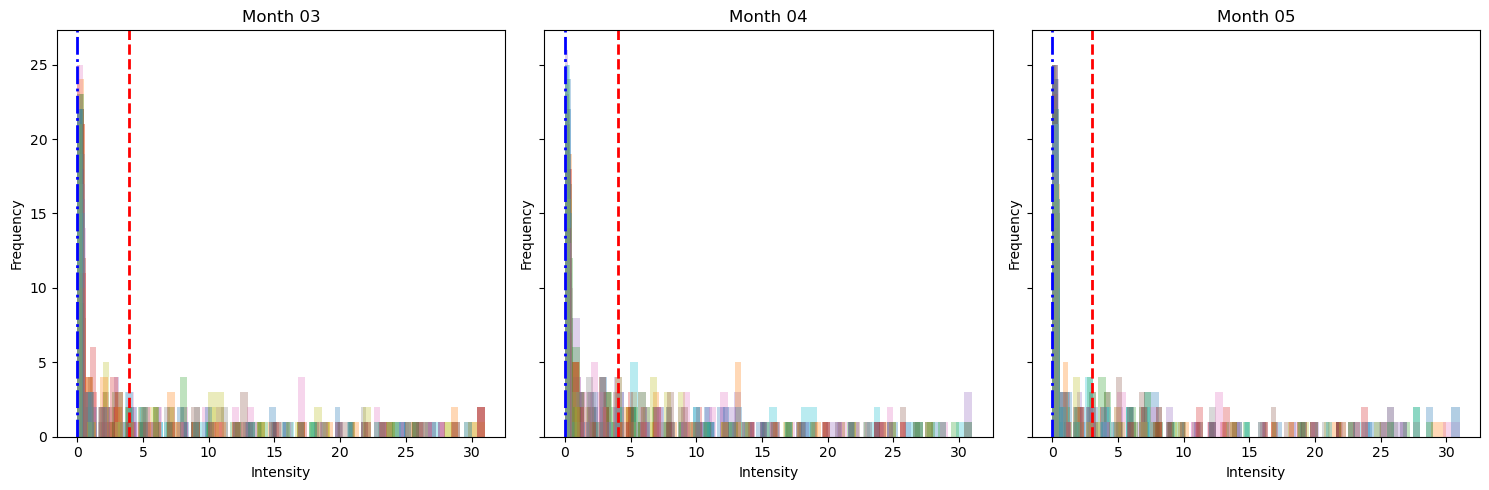

In [12]:
print_summary_statistics(2023, ["03", "04", "05"], handler)
plot_intensity_distributions(2023, ["03", "04", "05"], handler)

### 2. We can now estimate the exposure


After creating the hazard, we proceed to create the exposure. Exposure refers to the collection of assets, individuals, infrastructure, and other elements within a specific area of interest that may be vulnerable to hazards. It encompasses their geographical coordinates, values, and other relevant information. There are two main options for obtaining exposure data:

1. **CLIMADA's Ready-to-Use Data**:
CLIMADA offers pre-existing exposure data called LitPop. LitPop combines estimates of asset value, economic activity, or population based on nightlight intensity (Lit) and population count data (Pop). The formula for disaggregating asset exposure value to grid points is proportional to:

$$
Litpop = Lit^m \cdot Pop^n
$$



where \(m\) and \(n\) are user-defined exponents (default values are \(m=n=1\)). 

LitPop can be set to focus on different socio-economic indicators such as:

- Produced Capital ('pc'): Uses infrastructure and assets as proxies for exposure.
- Population Count ('pop'): Uses population density as a proxy.
- Gross Domestic Product ('gdp'): Uses economic output as a measure of exposure.
- Other modes include income group ('income_group'), household wealth ('tw' or 'nfw'), normalized values ('norm'), or raw nightlight intensity ('none').

The default mode provides information on USD assets, while setting `fin_mode='pop'` provides population counts. Users can adjust the weight between GDP and population in LitPop using exponents such as, Population-Weighted `(1, 0)` or  GDP-Weighted`(0, 1)` depending on the desired focus. For example:

$$
Population^1 \cdot GDP^0
$$

More details can be found in the [LitPop documentation](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_LitPop.html).



2. **Custom Data**:
If you have your own exposure data, you can provide it in formats such as `pandas.DataFrame`, `geopandas.GeoDataFrame`, or an Excel file. This allows users to define exposed elements with their own asset values, economic activity metrics, or population data. For further customization details, refer to the [Exposures documentation](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures.html).

>**Tip:** The LitPop population data combines gridded night lights from NASA at a resolution of approximately 500 meters (15 arcseconds) and gridded population data from CIESIN at a resolution of about 1 km (30 seconds). Therefore, LitPop exposures can be retrieved at a maximum resolution of about 1 km, depending on the input data. The resolution can be set using the "res_arcsec" parameter. [More information](https://essd.copernicus.org/articles/12/817/2020/)   

We will now turn our attention to the LitPop data to be used in this demonstration. But first, there are a few points to mention:

- You can provide either single countries or a list of countries (e.g., ISO3 codes like `'CHE'` for Switzerland or `'DEU'` for Germany).
- Default LitPop exposure entities can be loaded for specific countries and years.
- To include all EU countries, add their ISO3 codes (e.g., `['AUT', 'BEL', 'BGR', ...]`).
- Resolution can be adjusted using the parameter `res_arcsec`, with the default being 30 arcseconds (~1 km). Higher resolutions (e.g., 15 arcseconds) may require more computational resources.
- Sub-national GDP data can be used as an intermediate downscaling layer for countries with large regional differences by activating `admin1_calc=True`.


In [13]:
from climada.util.api_client import Client

client = Client()

# Fetch the list of LitPop dataset infos for Switzerland
litpop_datasets = client.list_dataset_infos(
    data_type="litpop", properties={"country_name": ["Switzerland"]}
)
litpop_df = client.into_datasets_df(litpop_datasets)
litpop_df  # The 150 arcsec is app 4.631 kilometers


data_type data_type_group                                  uuid  \
0    litpop       exposures  d99916c1-343c-4826-96d6-d11987e4399f   
1    litpop       exposures  9203fb46-5d65-45a8-98d7-ad439463ae2b   
2    litpop       exposures  4aafe246-c3bf-4f1e-b3d4-79831abf9d91   

                             name version  status   doi  \
0  LitPop_assets_pc_150arcsec_CHE      v3  active  None   
1        LitPop_pop_150arcsec_CHE      v3  active  None   
2            LitPop_150arcsec_CHE      v3  active  None   

                                         description  \
0  LitPop asset value exposure per country: Gridd...   
1  LitPop population exposure per country: Gridde...   
2  LitPop asset value exposure per country: Gridd...   

                                     license  \
0  Attribution 4.0 International (CC-BY-4.0)   
1  Attribution 4.0 International (CC-BY-4.0)   
2  Attribution 4.0 International (CC-BY-4.0)   

                    activation_date expiration_date res_arcsec exponents  \
0  2024-06-07 08:21:45.678322+00:00            None        150     (3,0)   
1  2024-06-07 08:21:52.088193+00:00            None        150     (0,1)   
2  2024-06-07 08:21:55.124056+00:00            None        150     (1,1)   

  fin_mode spatial_coverage  climada_version date_creation country_iso3alpha  \
0       pc          country  v4.1.1 (v3.1.2)     2022-6-30               CHE   
1      pop          country  v4.1.1 (v3.1.2)     2022-6-30               CHE   
2       pc          country  v4.1.1 (v3.1.2)     2022-6-26               CHE   

  country_name country_iso3num  
0  Switzerland             756  
1  Switzerland             756  
2  Switzerland             756

2025-03-24 15:26:03,409 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2025-03-24 15:26:03,654 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2025-03-24 15:26:03,655 - climada.entity.exposures.base - INFO - category_id not set.
2025-03-24 15:26:03,655 - climada.entity.exposures.base - INFO - cover not set.
2025-03-24 15:26:03,655 - climada.entity.exposures.base - INFO - deductible not set.
2025-03-24 15:26:03,655 - climada.entity.exposures.base - INFO - centr_ not set.
2025-03-24 15:26:03,656 - climada.util.coordinates - INFO - Setting geometry points.


<GeoAxes: title={'center': "LitPop Exposure for ['CHE'] at 30 as, year: 2018, financial mode: pop,\nexp: (1, 0), admin1_calc: False"}>

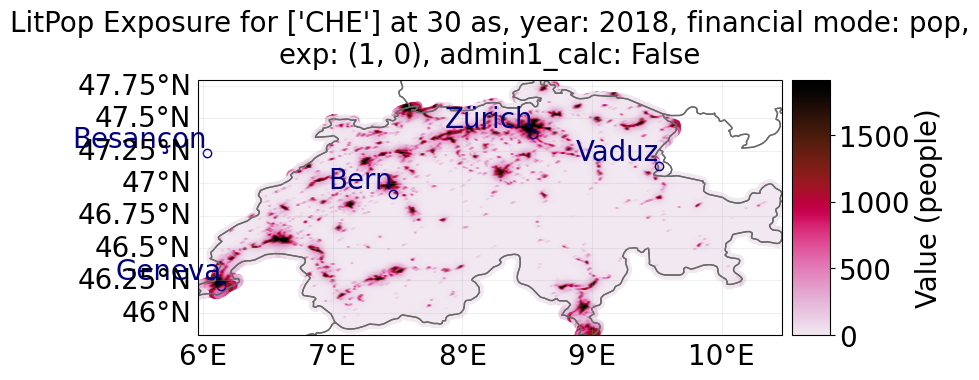

In [14]:
# Plot population distribution
exposure = LitPop.from_countries("CHE", res_arcsec=30, fin_mode="pop", exponents=(1, 0))
exposure.set_geometry_points()
exposure.plot_scatter(label="Population")


## 3. Set up vulnerability and calculate potential damages

### Creating an Impact Function

This tutorial will walk you through creating an impact function in CLIMADA, broken down into simple steps anyone can understand.

---

#### What is an Impact Function?

An impact function in CLIMADA describes how much damage a hazard (like a storm or flood) causes, depending on how strong it is.

It links together three main concepts:

- **Intensity**: How strong the hazard is (e.g. wind speed, flood depth).
- **MDD (Mean Degree of Damage)**: How badly things get damaged (from 0 = no damage to 1 = total destruction).
- **PAA (Proportion of Assets Affected)**: What fraction of exposed assets (e.g. buildings, infrastructure) are affected by the hazard.

Think of it as a mathematical way to answer the question:

*"If a hurricane with wind speed X hits, what percentage of buildings will be damaged, and how badly?"*

---

#### Creating a Simple Impact Function

Let’s create a basic "dummy" impact function to understand the concept. We’ll use synthetic values to keep it simple.

```python

# Define intensity values from 0 to 10 (e.g. wind speed)
intensity = np.linspace(0, 10, 100)

# Define damage from 0 (no damage) to 1 (total damage)
mdd = np.linspace(0, 1, 100)

# Assume all assets are affected (100%) at every intensity
paa = np.ones(100)

Here, we create a "dummy" impact function to examine the interaction of metrix selected in LitPop. The impact function is created by utilizing the previously generated hazard and exposure datasets.

The impact function is crafted, incorporating the following key elements, [click for more information](https://climada-python.readthedocs.io/en/latest/tutorial/climada_engine_Impact.html):

* impf: An ImpactFunc object is instantiated with the provided parameters, including the hazard type, ID, intensity, MDD, PAA, and units for intensity and MDD. The impact function is labeled as "dummy".https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_Impact.html#impact-class-data-structure

* impact_func_set: An ImpactFuncSet object is created, representing a collection or set of impact functions. The impf_dum impact function is added to this set using the ImpactFuncSet constructor with [impf_dum] as the argument.

* impf_ras.check(): This line of code calls the check() method on the impf_ras impact function set. 



Loading exposure data...
2025-03-24 15:26:07,978 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2025-03-24 15:26:08,241 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2025-03-24 15:26:08,241 - climada.entity.exposures.base - INFO - category_id not set.
2025-03-24 15:26:08,241 - climada.entity.exposures.base - INFO - cover not set.
2025-03-24 15:26:08,241 - climada.entity.exposures.base - INFO - deductible not set.
2025-03-24 15:26:08,242 - climada.entity.exposures.base - INFO - centr_ not set.
Exposure data loaded successfully.
Calculating impact for initiation month 03...
2025-03-24 15:26:08,249 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2023/init03/valid06_08/hazard/TX30/TX30_boundsW4_S44_E11_N48.hdf5
Hazard data loaded successfully for initiation month 03.
2025-03-24 15:26:08,261 - climada.entity.exposures.base - INFO - Matching 70287 exposur

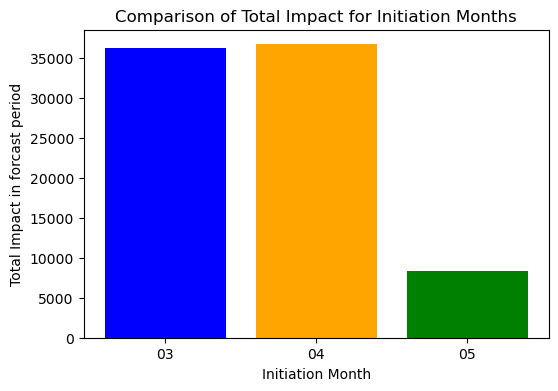

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from climada.hazard import Hazard
from climada.engine import ImpactCalc, Impact
from climada.entity.impact_funcs import ImpactFuncSet, ImpactFunc
from climada.util.config import CONFIG
import warnings
warnings.filterwarnings("ignore")

# Define numerical initiation months directly
initiation_month = ["03", "04", "05"]

# Define file paths and parameters
climada_base_path = CONFIG.hazard.copernicus.local_data.dir()
countries = ["CHE"]

# Load exposure data
try:
    print("Loading exposure data...")
    exposure = LitPop.from_countries(countries, res_arcsec=30, fin_mode="pop", exponents=(1, 0))
    print("Exposure data loaded successfully.")
except Exception as e:
    print(f"Error loading exposure data: {e}")
    exposure = None  

if exposure:
    intensity_array = np.linspace(0, 31, 20)
    mdd_array = np.clip(np.log1p(intensity_array) / np.log1p(31), 0, 1)
    paa_array = np.clip(intensity_array / 31, 0, 1)

    if_set = ImpactFuncSet()
    impact_func = ImpactFunc()
    impact_func.haz_type = index_metric
    impact_func.id = 1
    impact_func.intensity = intensity_array
    impact_func.mdd = mdd_array
    impact_func.paa = paa_array
    if_set.append(impact_func)

    saved_files = []
    
    for month_num in initiation_month:
        print(f"Calculating impact for initiation month {month_num}...")

        year_str = str(year_list[0])  
        hazard_dir = os.path.join(climada_base_path, "seasonal_forecasts", "dwd", "sys21", year_str, 
                                  f"init{month_num}", "valid06_08", "hazard", index_metric)

        if not os.path.isdir(hazard_dir):
            print(f"Warning: Hazard directory does not exist: {hazard_dir}")
            continue  # Skip this month if the folder is missing

        hazard_files = [f for f in os.listdir(hazard_dir) if f.startswith(f"{index_metric}_") and f.endswith(".hdf5")]
        if not hazard_files:
            print(f"Warning: No hazard file found in {hazard_dir}")
            continue  # Skip if no hazard files found

        hazard_file = hazard_files[0]  
        hazard_path = os.path.join(hazard_dir, hazard_file)

        try:
            hazard = Hazard.from_hdf5(hazard_path)
            print(f"Hazard data loaded successfully for initiation month {month_num}.")
        except Exception as e:
            print(f"Error loading hazard data for {month_num}: {e}")
            continue  # Skip if loading fails

        exposure.assign_centroids(hazard)
        impact = ImpactCalc(exposure, if_set, hazard).impact(save_mat=True)

        impact_folder = os.path.join(climada_base_path, "seasonal_forecasts", "dwd", "sys21", year_str,
                                     f"init{month_num}", "valid06_08", "impact", index_metric)
        os.makedirs(impact_folder, exist_ok=True)

        impact_file = os.path.join(impact_folder, hazard_file)  
        impact.write_hdf5(impact_file)
        saved_files.append(impact_file)
        print(f"Impact saved: {impact_file}")

    print("\nImpact calculations completed successfully.")

    if saved_files:
        print("\nImpact Files Saved at:")
        for file in saved_files:
            print(f" - {file}")

    # Load impact data if available
    impact_objects = []
    for file in saved_files:
        try:
            impact_objects.append(Impact.from_hdf5(file))
        except Exception as e:
            print(f"Error loading impact file {file}: {e}")

    # Plot comparison if impact data is available
    if impact_objects:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(
            initiation_month[:len(impact_objects)], 
            [impact.at_event.mean() for impact in impact_objects], 
            color=["blue", "orange", "green"]
        )
        ax.set_xlabel("Initiation Month")
        ax.set_ylabel("Total Impact in forcast period")
        ax.set_title("Comparison of Total Impact for Initiation Months")
        plt.show()

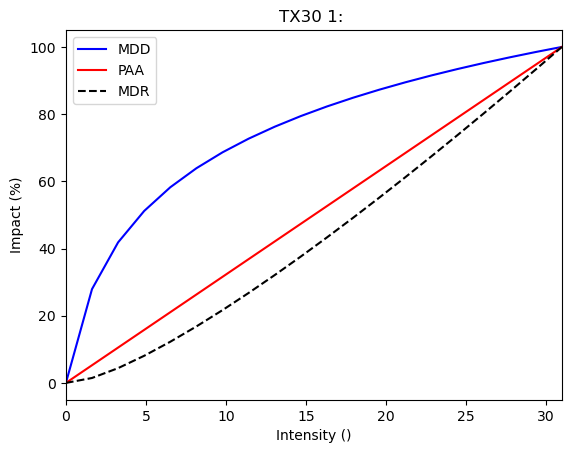

In [16]:
impact_func.plot();

In [17]:
# Load Impact objects into a dictionary
impacts = {
    "03": Impact.from_hdf5(saved_files[0]),
    "04": Impact.from_hdf5(saved_files[1]),
    "05": Impact.from_hdf5(saved_files[2])
}

for month in ["03", "04", "05"]:
    if month in impacts:
        total_impact = impacts[month].at_event.mean()
        print(f"Total Impact at Event Level for Initiation Month {month}: {total_impact:,.0f}")
    else:
        print(f"Warning: No impact data found for Initiation Month {month}")


Total Impact at Event Level for Initiation Month 03: 36,220
Total Impact at Event Level for Initiation Month 04: 36,666
Total Impact at Event Level for Initiation Month 05: 8,337


Now we can explore metrics to assess the differences in impact between different initiation periods.

- **Mean Impact**: The average impact per event, aggregated across all ensemble members for each event on a specific date.
- **Max Impact**: The highest impact recorded across all events on a given date.
- **Min Impact**: The lowest impact recorded, often indicating whether zero-impact events are present.
- **Standard Deviation (Std Dev)**: A measure of how much the impact varies around the mean. Useful to understand general variability, but can be influenced by extreme values.
- **Interquartile Range (IQR)**: The range between the 75th percentile (Q3) and the 25th percentile (Q1), representing the middle 50% of impact values. More robust to outliers than standard deviation and especially useful for skewed data.
- **Coefficient of Variation (CV)**: The ratio of standard deviation to the mean, indicating relative variability in the impact distribution. Helps compare variability across datasets with different magnitudes.
- **Percentage of Zero-Impact Events**: The proportion of events with no recorded impact, highlighting ensemble members or periods where forecasts predict no effects.
- **Skewness**: A measure of asymmetry in the impact distribution. A positive value indicates a long right tail (i.e., high-impact outliers), while a negative value suggests more low-impact events.
- **Kurtosis**: Indicates whether the impact distribution has a sharp peak and heavy tails (high kurtosis) or is more evenly spread out and flat (low kurtosis).

**Note**: While standard deviation is commonly used to measure variability, it assumes a symmetric distribution and can be distorted by outliers. In contrast, IQR provides a clearer picture of how most values are spread, especially in skewed or heavy-tailed impact distributions.

These statistics help compare the impact forecasts across different initiation periods and forescat months. High variability (high std dev or CV) suggests uncertainty in the predictions, while differences in skewness and kurtosis can indicate whether extreme events dominate the impact distribution. The percentage of zero-impact events highlights differences in forecasted exposure to hazards.

By comparing these metrics across initiation periods, users can assess forecast reliability, uncertainty, and the likelihood of extreme impact events.


In [27]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Store results for later display in a table
results = []
df_init_months = {}

for month in ["03", "04", "05"]:
    if month in impacts:
        impact_obj = impacts[month]
        dates = [datetime.fromordinal(int(d)).strftime("%Y-%m-%d") for d in np.unique(impact_obj.date)]

        # Extract impact per event
        impact_per_event = impact_obj.at_event
        df = pd.DataFrame({"date": impact_obj.date, "impact": impact_per_event})
        df_init_months[month] = df.copy()

        # Compute statistics per date
        impact_stats = df.groupby("date")["impact"].agg(
            mean="mean",
            max="max",
            min="min",
            std="std",
            q25=lambda x: x.quantile(0.25),
            q75=lambda x: x.quantile(0.75),
            skewness=lambda x: skew(x, nan_policy="omit"),
            kurt=lambda x: kurtosis(x, nan_policy="omit"),
            zero_impact=lambda x: (x == 0).sum() / len(x) * 100
        ).reset_index()

        impact_stats["iqr"] = impact_stats["q75"] - impact_stats["q25"]
        impact_stats["cv"] = impact_stats["std"] / impact_stats["mean"] * 100

        for date, row in zip(dates, impact_stats.itertuples(index=False)):
            results.append([
                month,
                date,
                "{:,.1f}".format(row.mean),
                "{:,.1f}".format(row.max),
                "{:,.1f}".format(row.min),
                "{:,.1f}".format(row.std),
                "{:,.1f}".format(row.iqr),
                "{:,.1f}".format(row.cv),
                round(row.skewness, 2),
                round(row.kurt, 2),
                round(row.zero_impact, 1)
            ])
    else:
        print(f"Warning: No impact data found for Initiation Month {month}")

# Create DataFrame for display
df_results = pd.DataFrame(results, columns=[
    "Initiation Month", "Date", "Mean Impact", "Max Impact", "Min Impact",
    "Std Dev", "IQR", "CV (%)", "Skewness", "Kurtosis", "Zero-Impact (%)"
])
df_results["Date"] = pd.to_datetime(df_results["Date"])
df_results



Initiation Month       Date Mean Impact   Max Impact Min Impact    Std Dev  \
0               03 2023-06-01        65.4      3,223.2        0.0      455.7   
1               03 2023-07-01    26,173.6  1,135,684.8        0.0  160,535.5   
2               03 2023-08-01    82,420.5  1,365,675.5        0.0  246,913.5   
3               04 2023-06-01       233.6     11,677.7        0.0    1,651.5   
4               04 2023-07-01    18,947.0    381,940.3        0.0   60,330.4   
5               04 2023-08-01    90,817.0    784,142.4        0.0  178,112.2   
6               05 2023-06-01         0.0          0.0        0.0        0.0   
7               05 2023-07-01     3,020.7     55,111.4        0.0    9,143.9   
8               05 2023-08-01    21,991.4    399,139.8        0.0   66,130.3   

        IQR CV (%)  Skewness  Kurtosis  Zero-Impact (%)  
0       0.0  696.9      6.86     45.01             94.0  
1      10.1  613.3      6.80     44.51             62.0  
2  31,719.8  299.6      3.91     15.33             38.0  
3       0.0  707.1      6.86     45.02             98.0  
4   5,931.7  318.4      4.80     24.89             42.0  
5  70,682.8  196.1      2.38      5.32             26.0  
6       0.0    nan       NaN       NaN            100.0  
7       0.0  302.7      4.23     19.82             80.0  
8   3,285.4  300.7      4.35     20.43             60.0

Below the plot shows the total population impacted by heat-related events for each ensemble member, sorted by impact.

- The X-axis is the ranked index of ensemble members (not the true ensemble ID), sorted by increasing impact.
- The Y-axis shows the total number of people affected in each simulation.
- Different colors represent different forecast initiation months (March, April, May).

The plot helps to undertand the **distribution and extremes** of potential impacts:

- It reveals the shape of the impact distribution across ensemble members.
- It shows how many members lead to low vs. high impact.
- It highlights that a **small number of members** (e.g. top 10 out of 150) may drive **most of the expected risk**, revealing the **tail behavior** of the forecast.

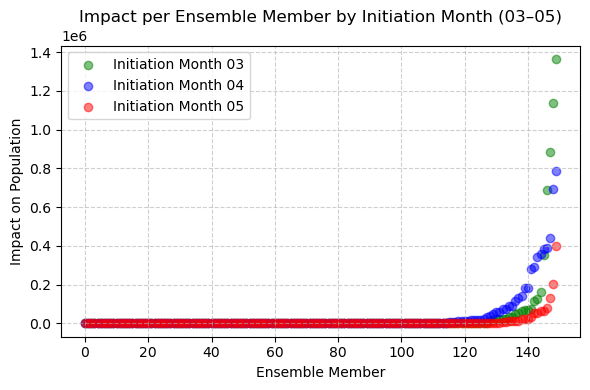

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to optionally store computed impact statistics per month
monthly_impact_stats = {}

# Compute impact summaries for each initiation month (not used in this plot, kept for potential use)
for month in ["03", "04", "05"]:
    if month in impacts:
        monthly_impact_stats[month] = impacts[month].calc_freq_curve(1 / np.linspace(1, 151, 150))
    else:
        print(f"Warning: No impact data found for Initiation Month {month}")

# Plotting impact values per ensemble member
fig, ax = plt.subplots(figsize=(6, 4))

# Assign a unique color to each month
colors = {"03": "green", "04": "blue", "05": "red"}

# Plot "sorted" impacts for each initiation month
for month in ["03", "04", "05"]:
    if month in df_init_months:
        df_plot = df_init_months[month].sort_values(by="impact", ascending=True).reset_index(drop=True)
        df_plot["ensemble_member"] = df_plot.index

        ax.scatter(
            df_plot["ensemble_member"],
            df_plot["impact"],
            label=f"Initiation Month {month}",
            color=colors[month],
            alpha=0.5
        )

# Customize plot
ax.set_title("Impact per Ensemble Member by Initiation Month (03–05)")
ax.set_xlabel("Ranked Ensemble Member")
ax.set_ylabel("Impact on Population")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



In [20]:
# Print event_id, event_name, date, and at_event for Initiation Month 03
print("Event IDs in Impact (03):", impacts["03"].event_id)
print("Event Names in Impact (03):", impacts["03"].event_name)
print("Event Dates in Impact (03):", impacts["03"].date)
print("Impact at Event Level (03):", impacts["03"].at_event)


Event IDs in Impact (03): [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150]
Event Names in Impact (03): ['member0', 'member0', 'member0', 'member1', 'member1', 'member1', 'member2', 'member2', 'member2', 'member3', 'member3', 'member3', 'member4', 'member4', 'member4', 'member5', 'member5', 'member5', 'member6', 'member6', 'member6', 'member7', 'member7', 'member7', 'member8', 'member8', 'member8', 'member9', 'member9', 'member9', 'memb

These plots show the forecasted number of people affected by climate hazards from June to August, for each ensemble member and forecast initiation month (March, April, May). Each line represents one ensemble member. The dashed line shows the mean forecast. The solid line indicates the median forecast. The shaded area visualizes ±1 standard deviation (forecast spread).


We can see that:
- Impact forecasts vary across ensemble members, reflecting uncertainty.
- Forecast variability increases with lead time (more spread in August).
- Forecasts become more refined from March to May as more recent data is used.
- Some ensemble members show extreme impacts. 

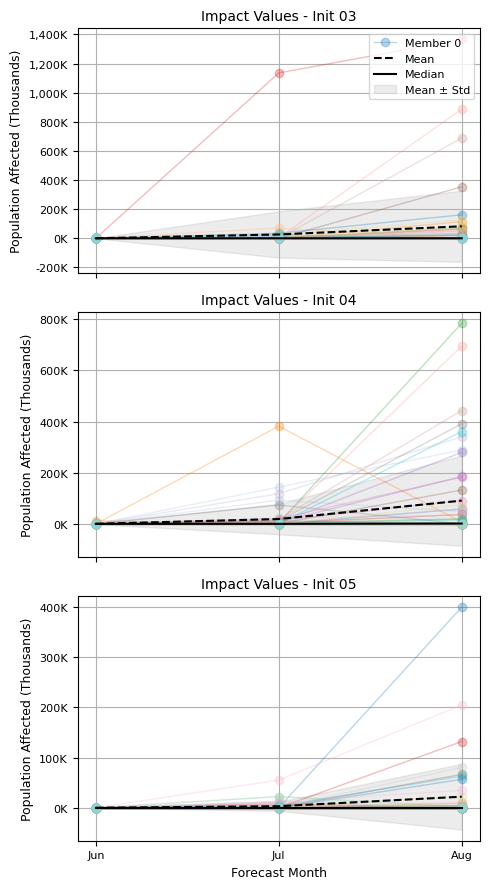

In [21]:
# Call the function for multiple initiation months
plot_individual_and_aggregated_impacts(year_list, index_metric,"03", "04", "05")

These plots display the percentage of ensemble members agreeing on different levels of forecasted population impacts for June, July, and August 2023, under different forecast initiation months (03, 04, 05). The y-axis shows the percentage of ensemble members that agree on a given impact level (x-axis, log-scaled population affected).

- **June Shows Low Agreement and Low Impact:** For all initiation months, most members forecast no impact in June, with mean and median impacts close to zero.
- **July and August Show Higher Impact and Spread:** Agreement shifts toward higher impact values, especially in August, though variability among members increases.
- **Long-Tailed Distributions:** High skewness in many plots indicates a few members predict significantly higher impacts than the rest.
- **Ensemble Divergence in August:** Wider impact spread and lower consensus reflect greater uncertainty in late summer heat-related events.

These plots help assess the distribution and consensus of forecasted impacts across ensemble members, highlighting months with higher risk and lower predictability.


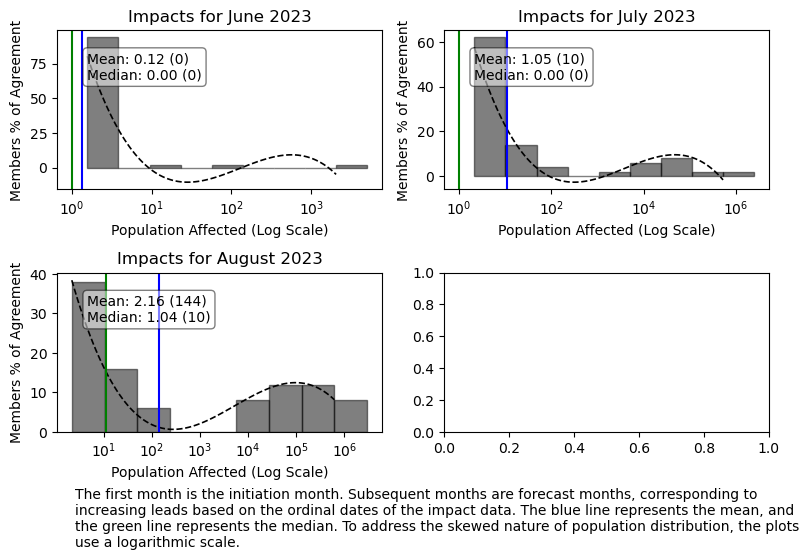

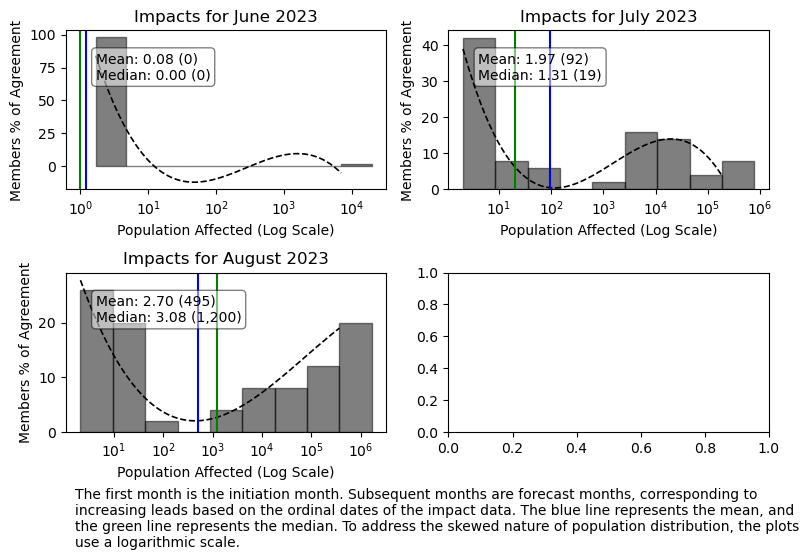

Skipping polynomial fit for June 2023 due to instability. ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value



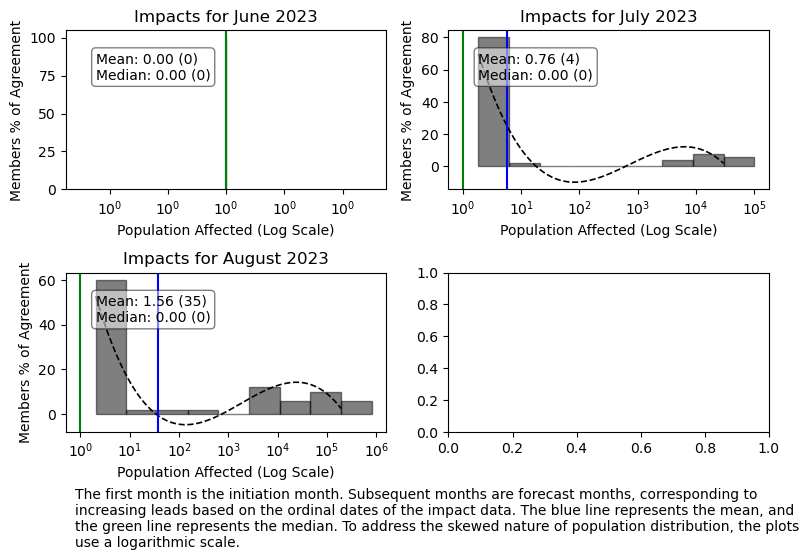

In [22]:
plot_impact_distributions(year_list, index_metric, ["03", "04", "05"])

### Spatial Consistency Analysis of Forecasted Impacts 

This section explores the spatial distribution of forecasted impacts across Switzerland, assessing how consistently ensemble members agree in different regions. Several key statistical metrics are plotted for each grid cell:

- **Mean:** Average impacted population across all ensemble members.
- **Median:** Middle value, useful for identifying typical outcomes unaffected by extremes.
- **Standard Deviation:** Measures variability among ensemble members, highlighting areas of uncertainty.
- **Max:** Highest impact forecasted by any member, showing worst-case scenarios.
- **Min:** Lowest impact (often zero), indicating areas where no impact is projected.

This spatial breakdown complements the temporal and statistical summaries by showing *where* impacts are expected and *how robust* these signals are across the forecast ensemble.


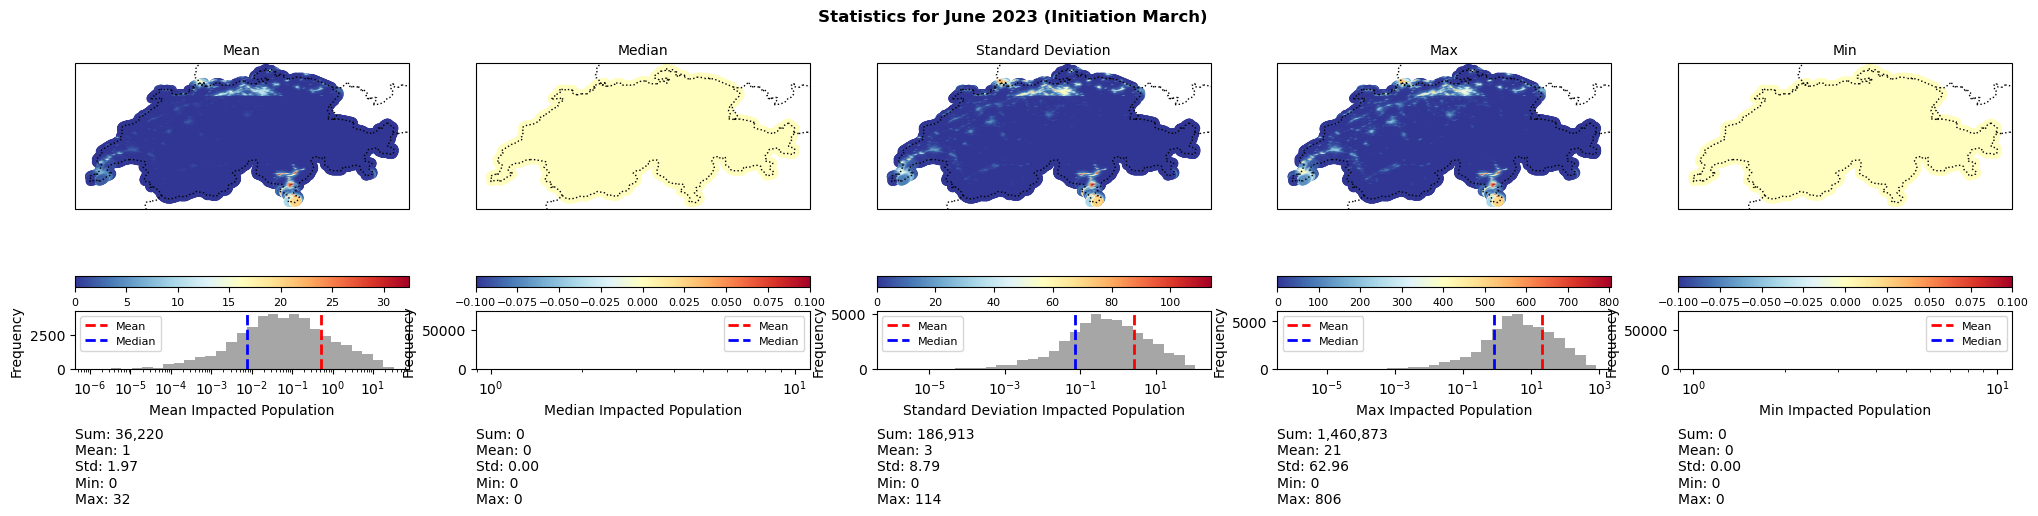

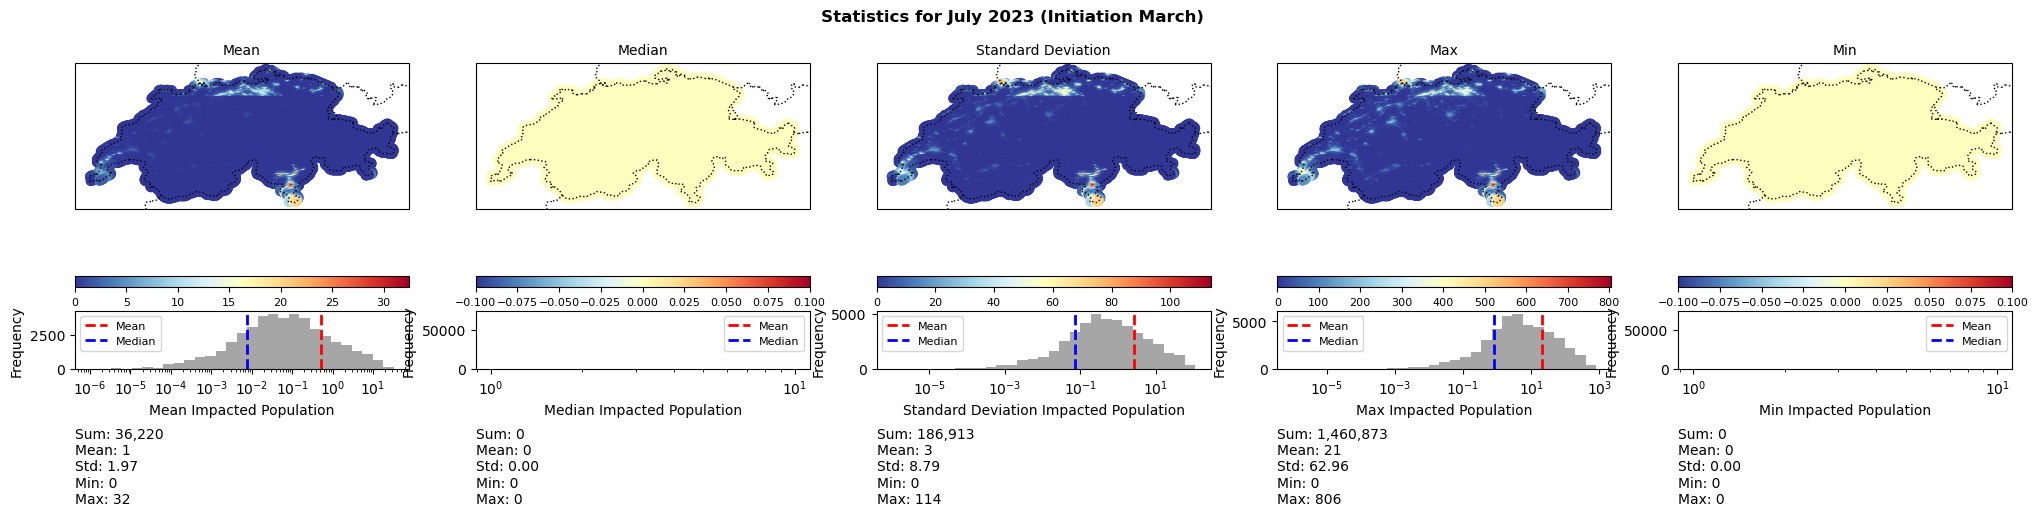

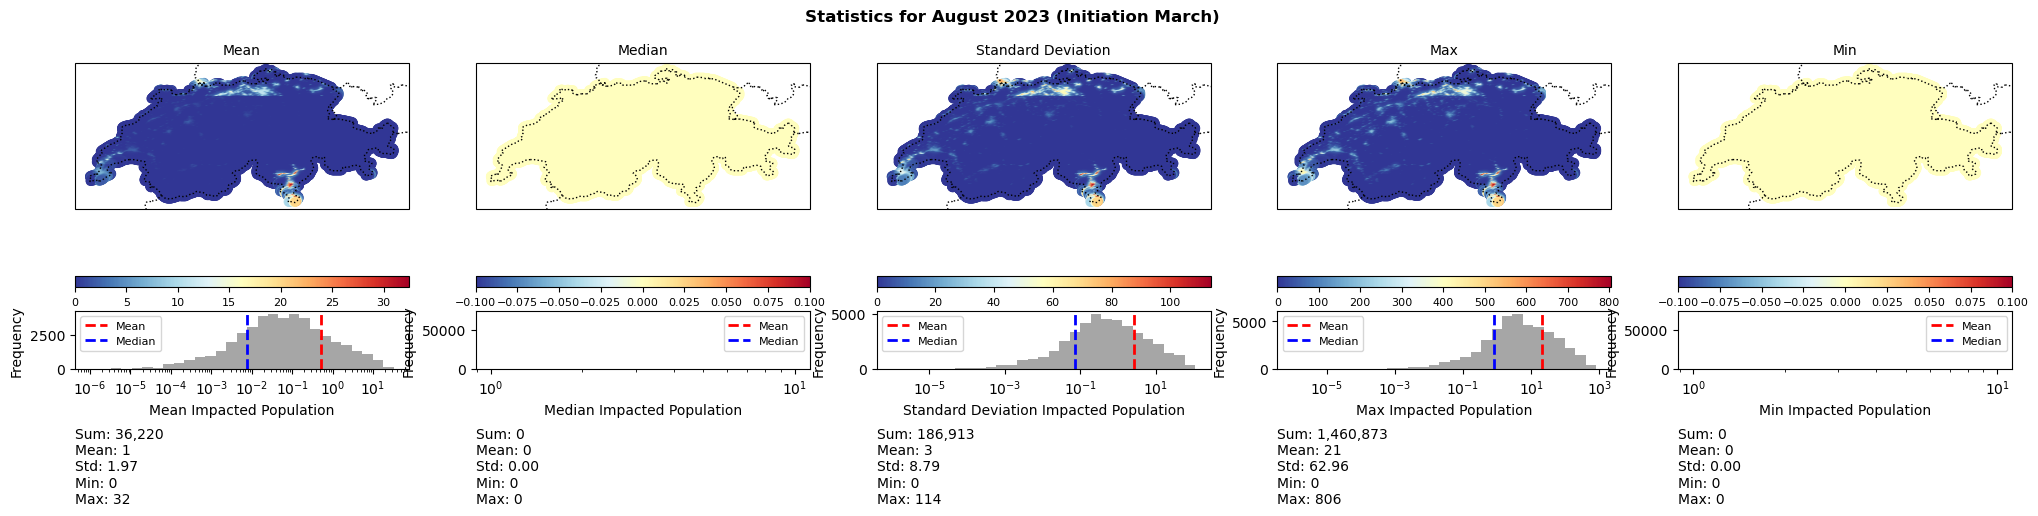

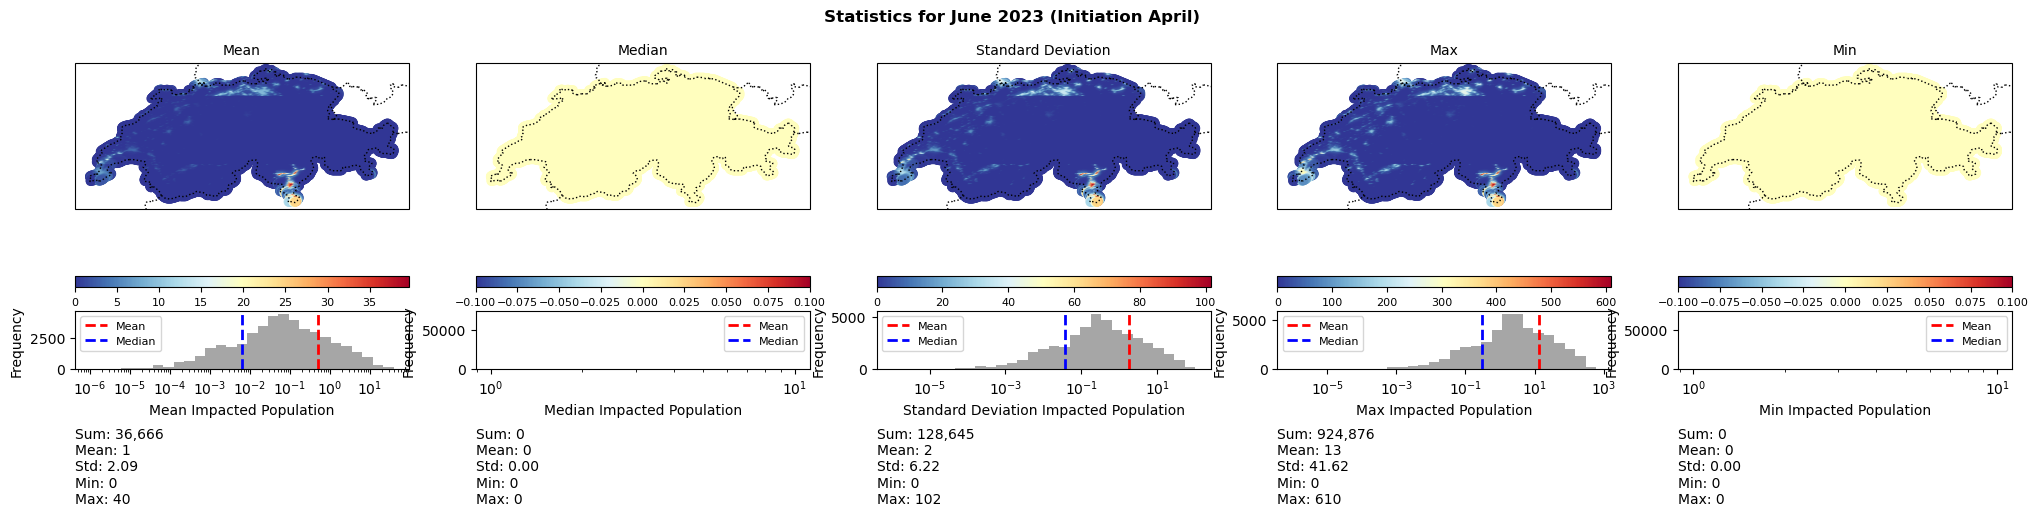

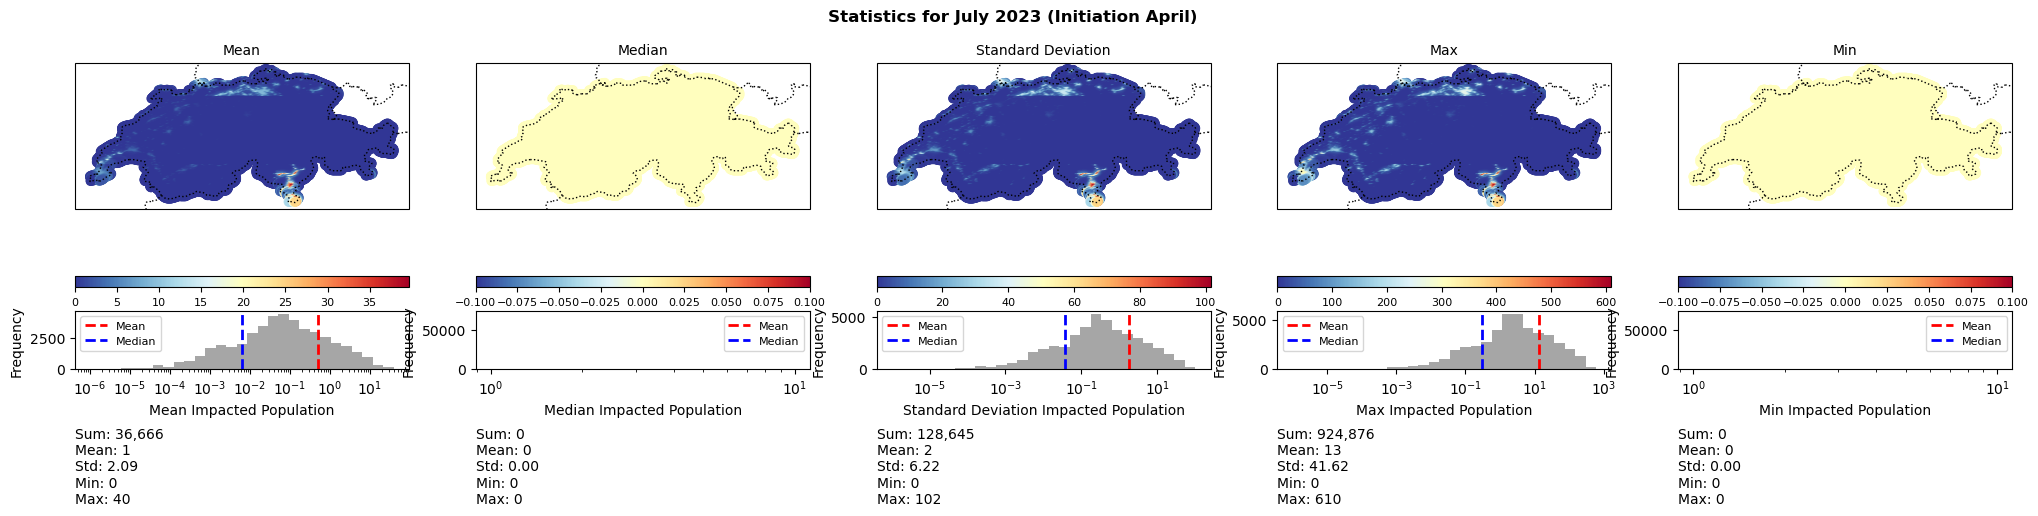

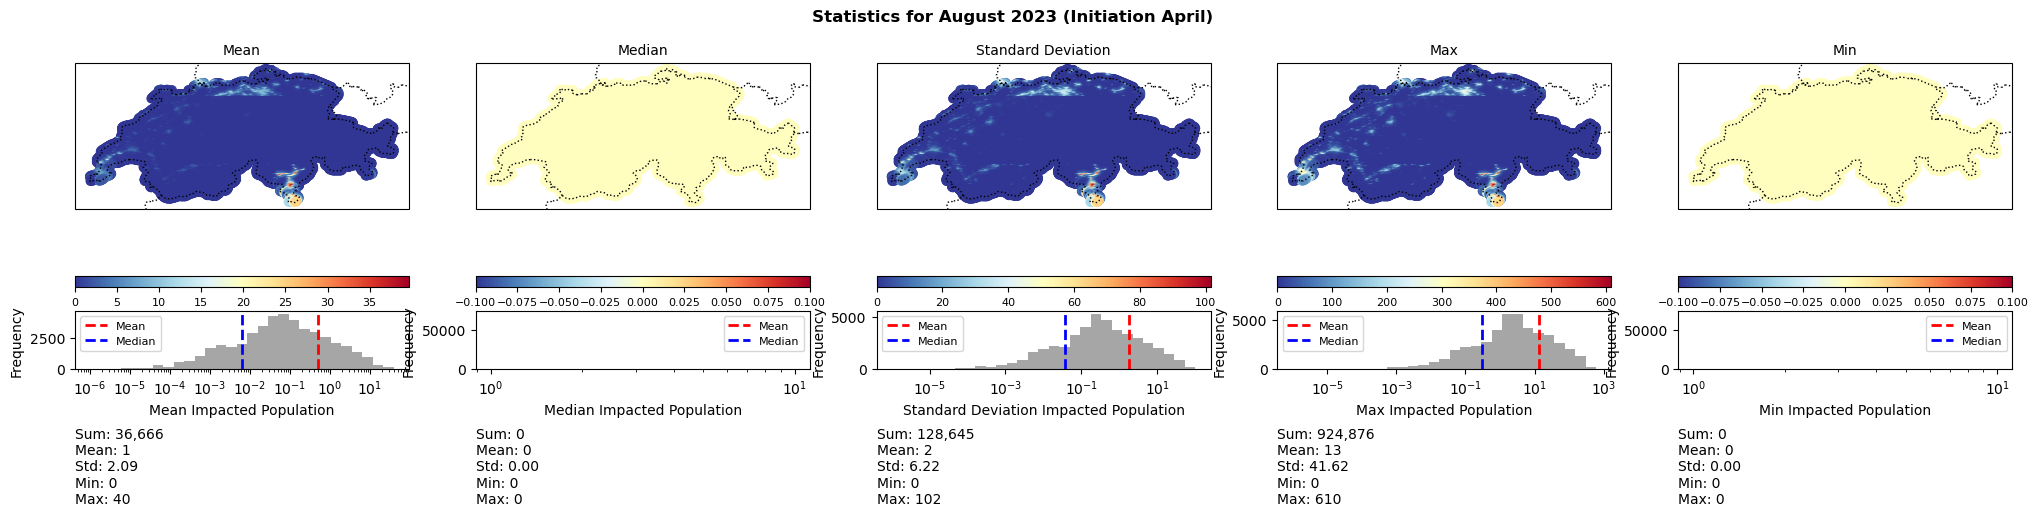

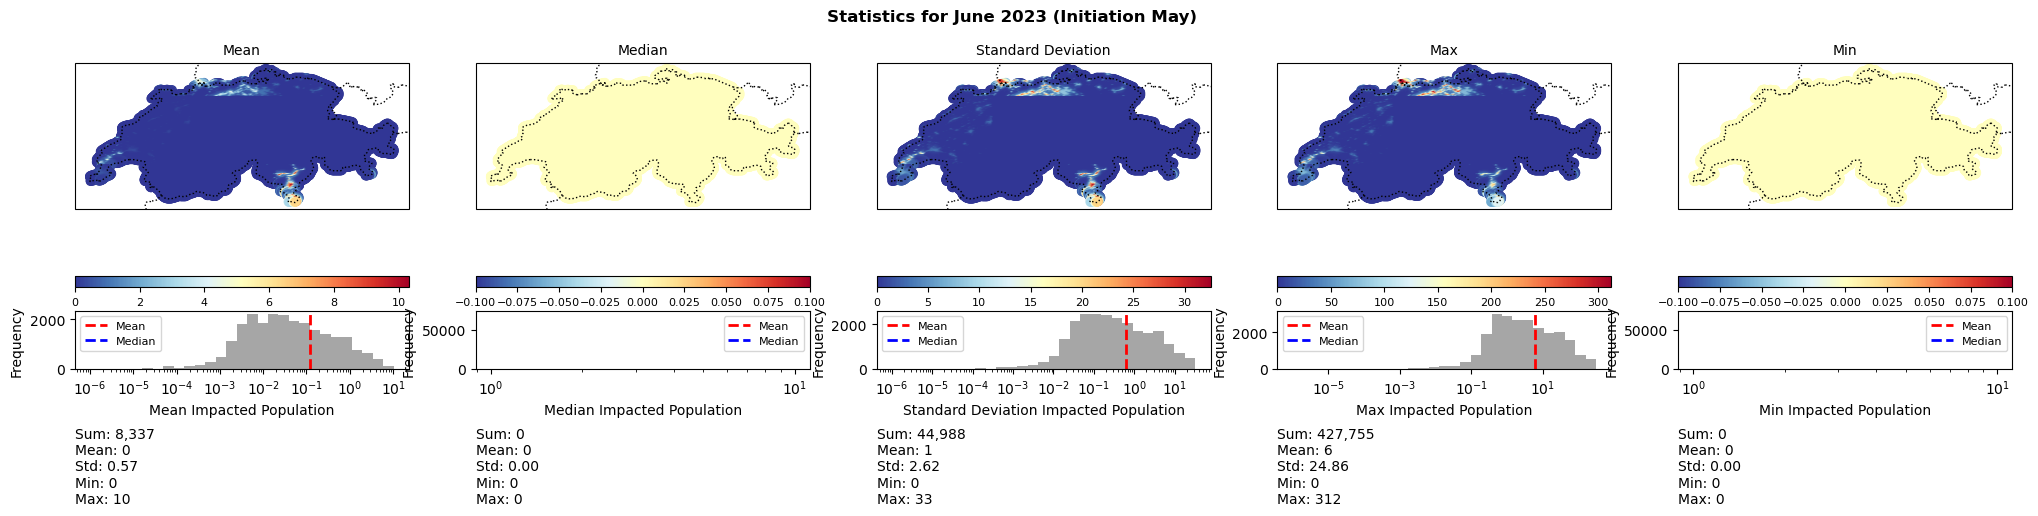

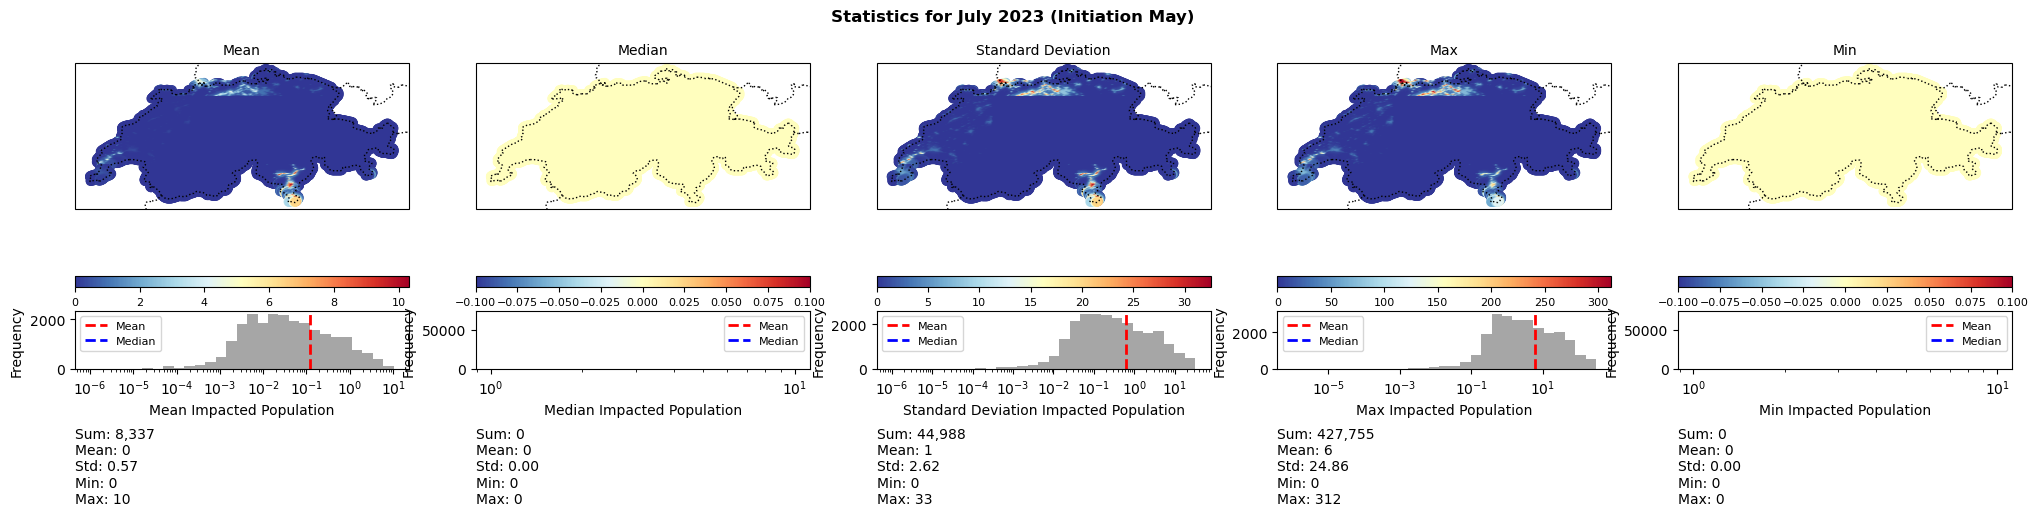

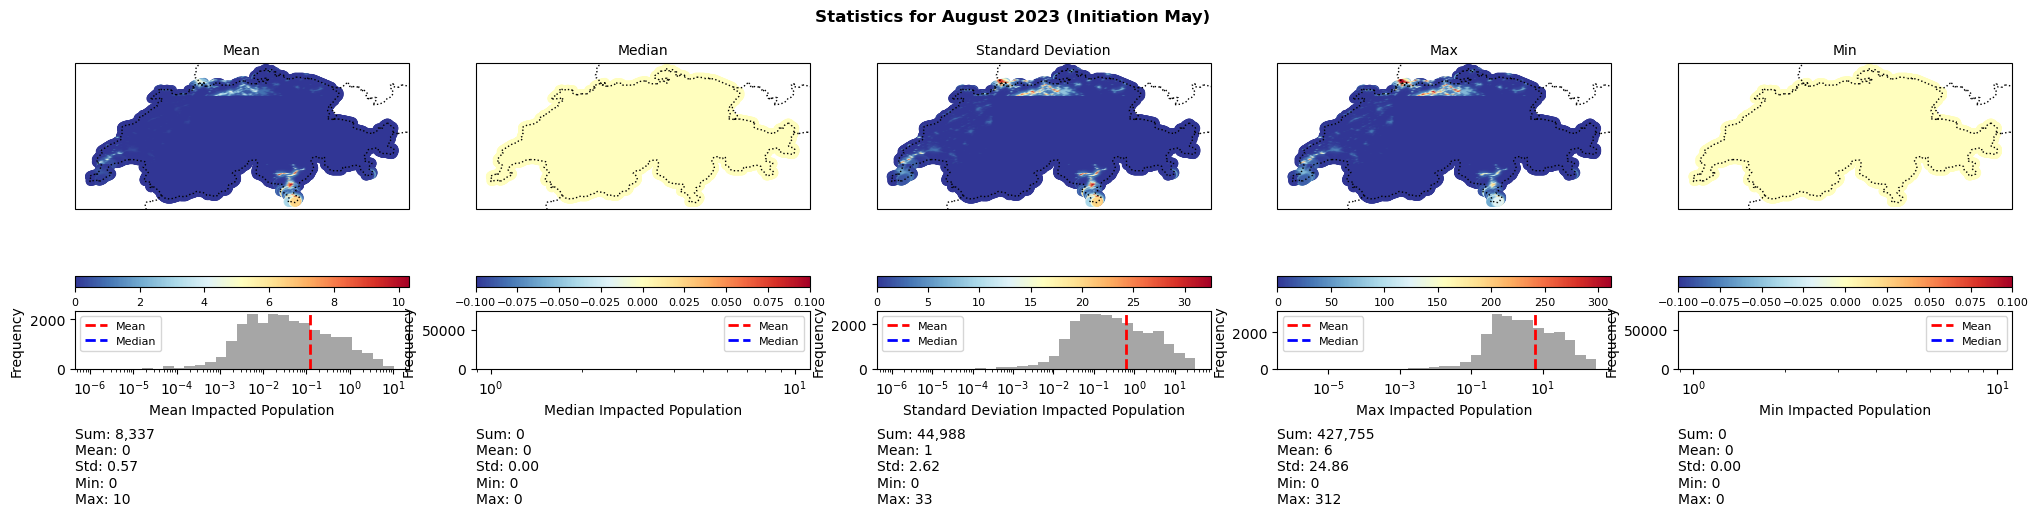

In [23]:
plot_statistics_per_location([2023], "TX30", "03", "04", "05", scale="log")

This section evaluates the spatial distribution of forecasted impacts and the agreement among ensemble members, providing insight into the spatial coherence and reliability of the forecast.

Each row in the figure contains three panels:

1. **Log-Transformed Impact Metric:**
   - Shows either the mean, maximum, or 95th percentile of the exposed population across ensemble members, in log scale.
   - Highlights the intensity and spatial concentration of impacts.

2. **High Agreement Map (>70%):**
   - Highlights regions where at least 70% of ensemble members agree that the local value of the selected metric (e.g. mean or 95th percentile) falls within one standard deviation of the ensemble distribution.
   - These areas indicate high model consensus and more robust forecast signals.

3. **Percentage of Members Agreement:**
   - Displays the full range of agreement, showing the percentage of ensemble members whose forecasted impact values fall near the ensemble mean at each location.
   - Useful for detecting uncertain regions with low consensus.

These diagnostics help assess **where the forecast is spatially consistent**, and guide confidence in forecast-based impact applications.


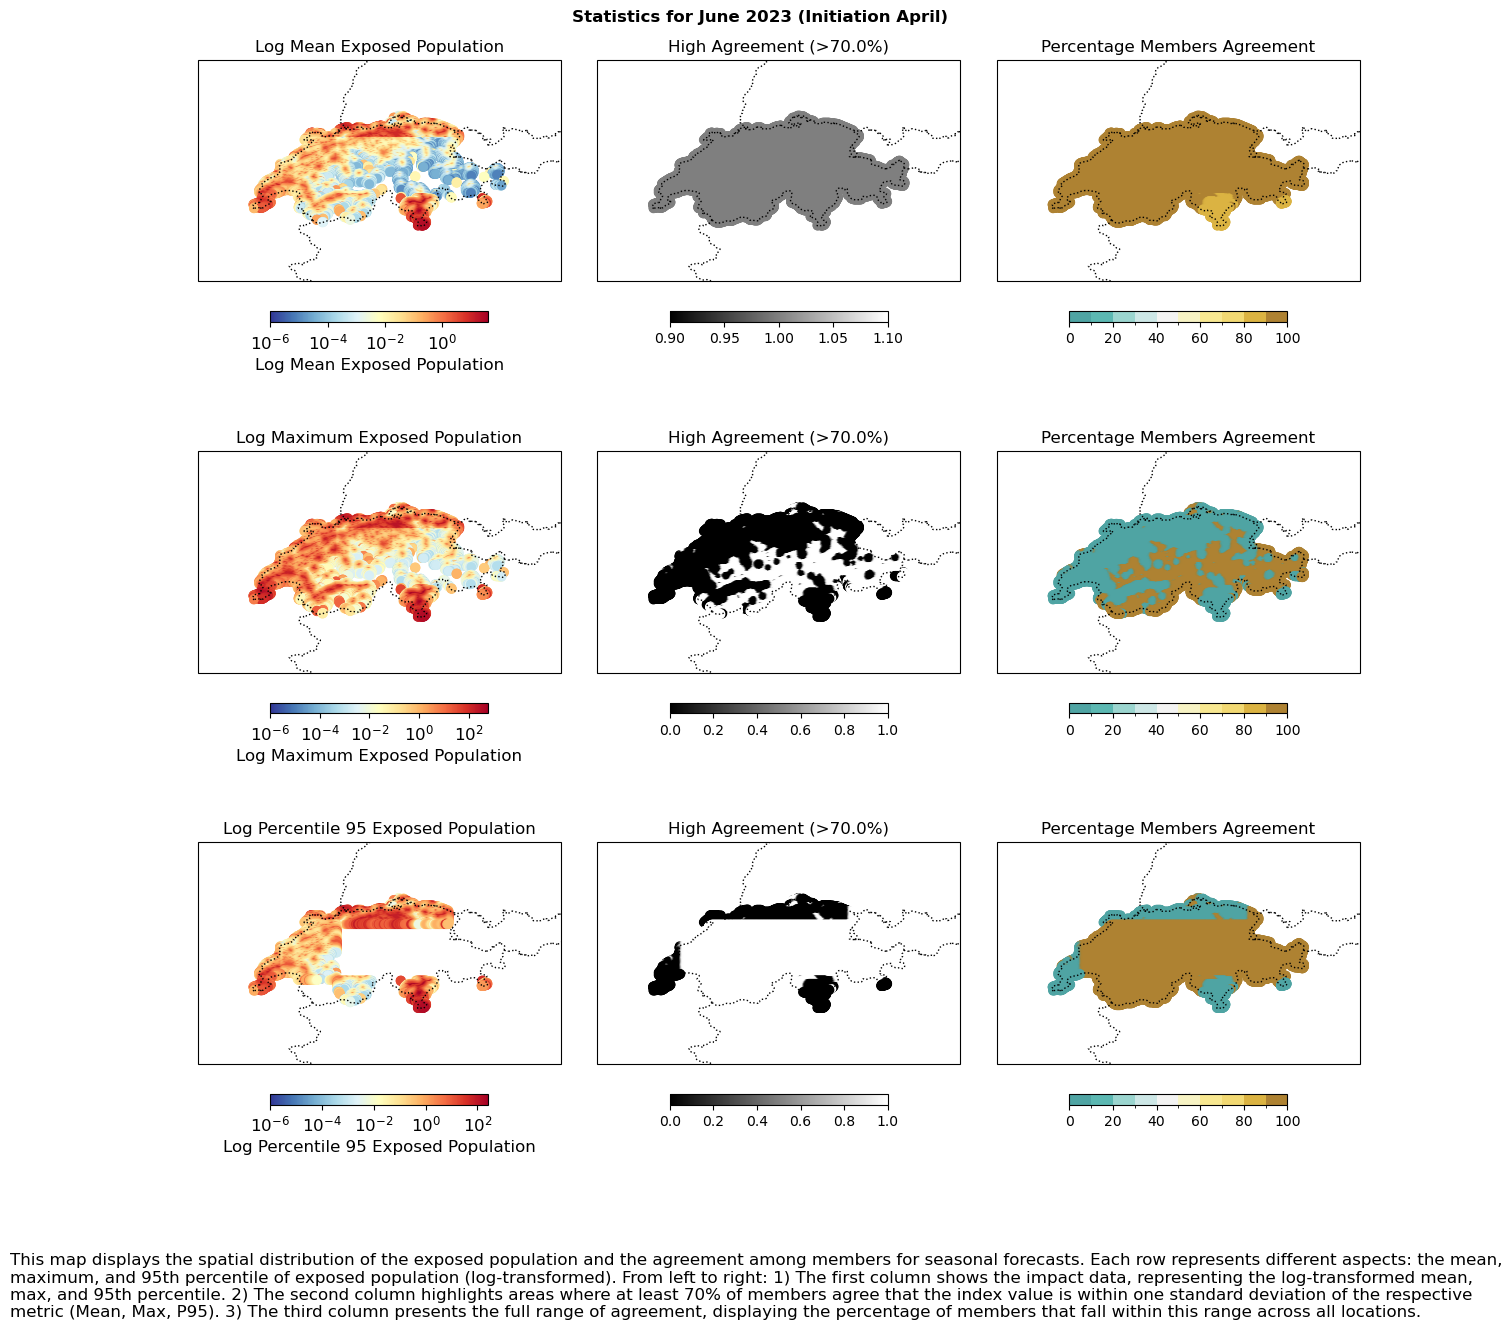

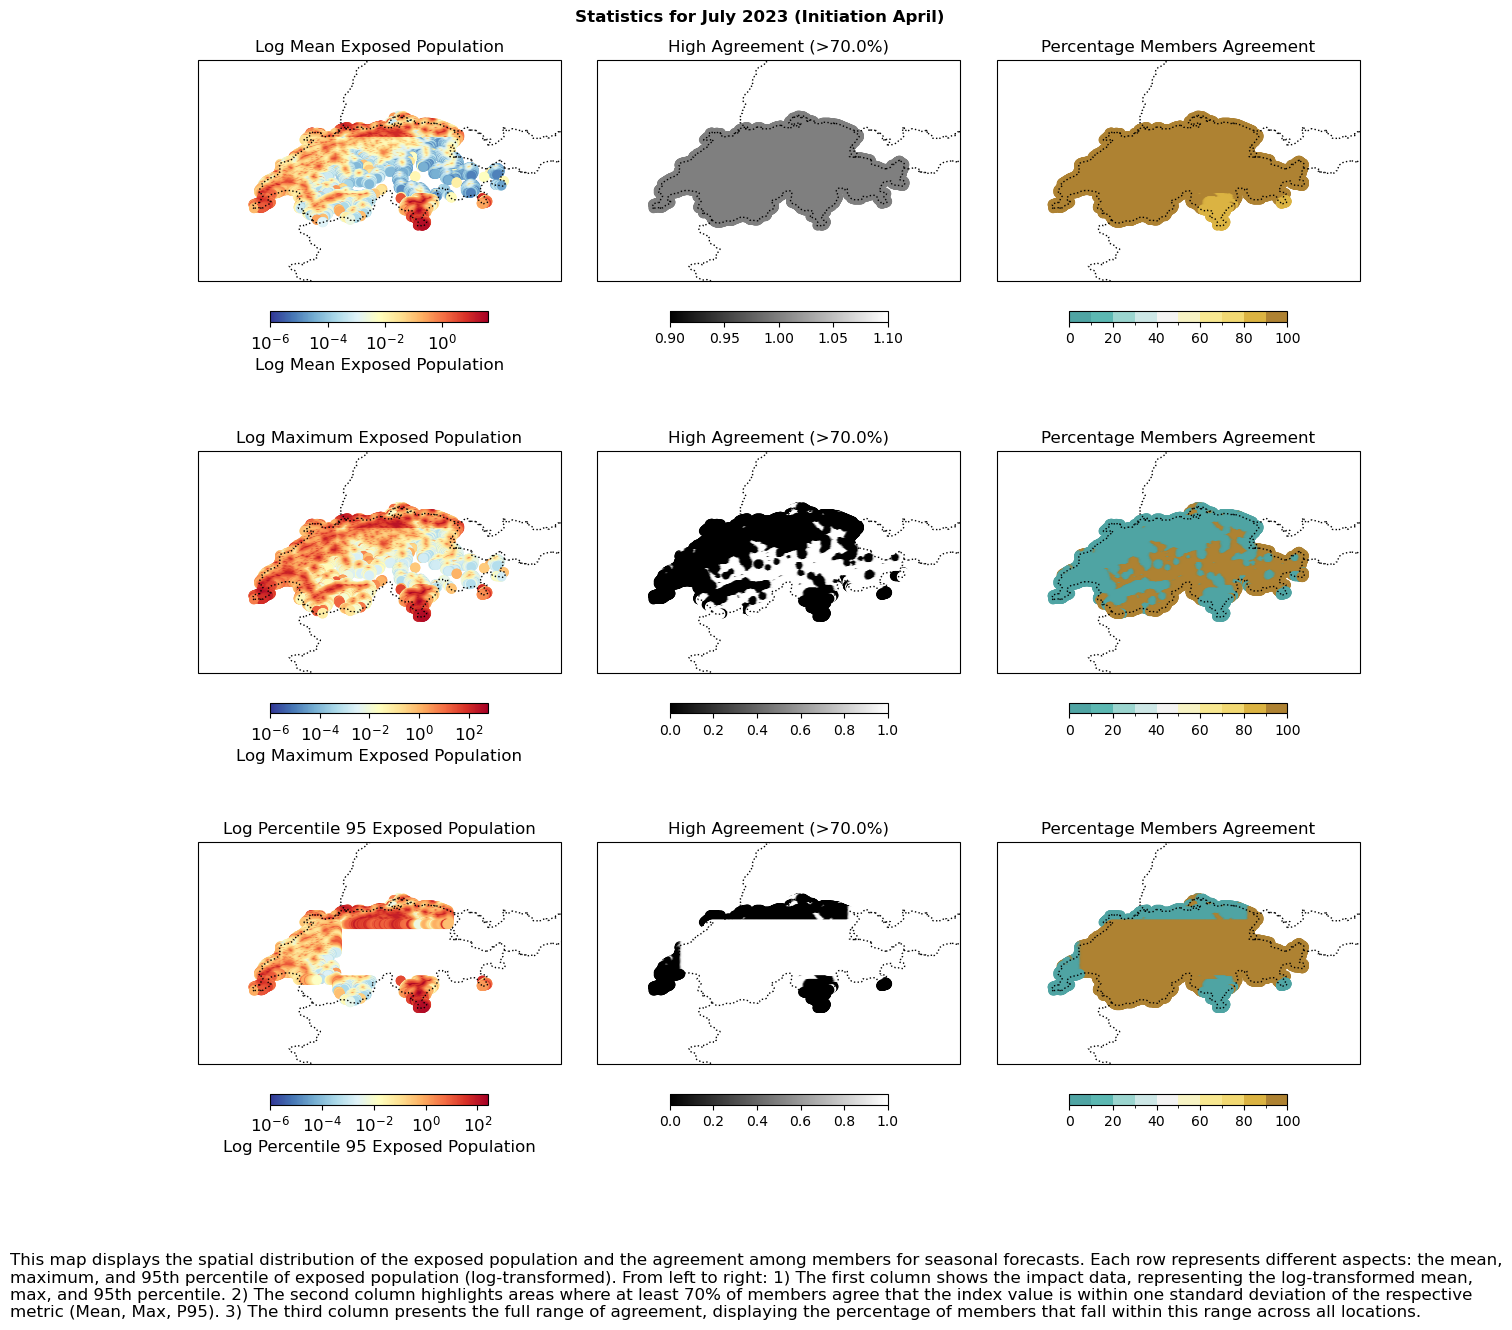

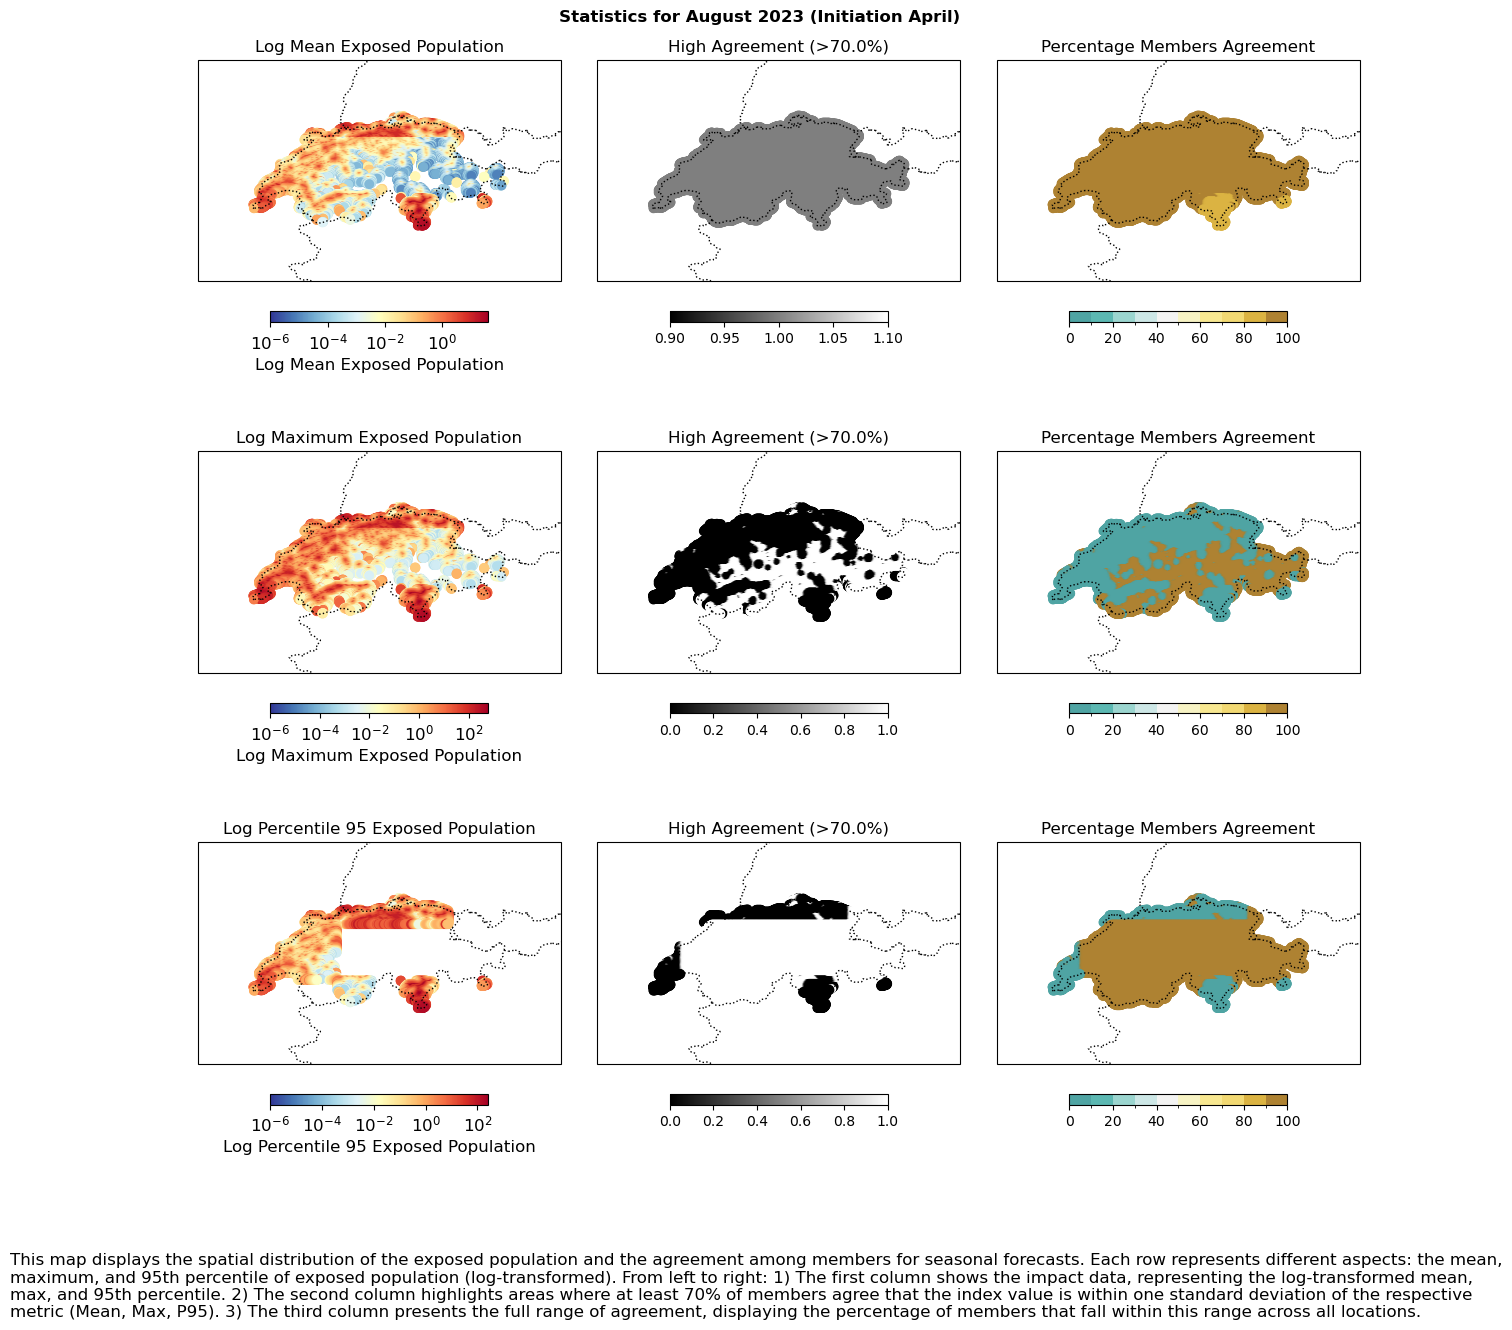

In [24]:
plot_statistics_and_member_agreement([2023], "TX30", 0.7, "04")

In [25]:
impacts["04"].coord_exp

array([[47.79583333,  8.54583333],
       [47.79583333,  8.55416667],
       [47.79583333,  8.5625    ],
       ...,
       [45.82916667,  8.9875    ],
       [45.82916667,  8.99583333],
       [45.82916667,  9.00416667]])

In [26]:
import xarray as xr
# Define the correct path as a string
path = "/Users/daraya/climada/data/copernicus_data/seasonal_forecasts/dwd/sys21/2022/init04/valid06_08/indices/TX30/TX30_boundsW4_S44_E11_N48_monthly.nc"
ds = xr.open_dataset(path, engine="netcdf4")
ds

<xarray.Dataset> Size: 34kB
Dimensions:    (latitude: 4, longitude: 7, step: 3, number: 50)
Coordinates:
  * latitude   (latitude) float64 32B 47.82 46.82 45.82 44.82
  * longitude  (longitude) float64 56B 4.954 5.954 6.954 7.955 8.955 9.955 10.96
    time       datetime64[ns] 8B ...
    surface    float64 8B ...
  * step       (step) <U7 84B '2022-06' '2022-07' '2022-08'
  * number     (number) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
Data variables:
    TX30       (number, step, latitude, longitude) int64 34kB ...

In [34]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def extract_statistics(file_path, forecast_months):
    """Extract tropical nights statistics from a dataset for the given months."""
    try:
        ds_stats = xr.open_dataset(file_path, engine="netcdf4")
        stats = {
            "Mean": ds_stats["ensemble_mean"].sel(step=forecast_months).mean(dim=["latitude", "longitude"]),
            "Median": ds_stats["ensemble_median"].sel(step=forecast_months).mean(dim=["latitude", "longitude"]),
            "Max": ds_stats["ensemble_max"].sel(step=forecast_months).mean(dim=["latitude", "longitude"]),
            "Min": ds_stats["ensemble_min"].sel(step=forecast_months).mean(dim=["latitude", "longitude"]),
            "Std": ds_stats["ensemble_std"].sel(step=forecast_months).mean(dim=["latitude", "longitude"]),
        }
        return pd.DataFrame({key: val.values for key, val in stats.items()}, index=forecast_months)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def forecast_skills_metrics(forecast_year, initiation_months, forecast_months, handler, index_metric="TX30"):
    """
    Plot SMR, Spread, Mean ± Std, Min-Max Range, and Median for given months
    using ensemble statistics NetCDF files per init month.
    """
    forecast_months_fmt = [f"{forecast_year}-{m}" for m in forecast_months]
    file_paths = []

    for init_month in initiation_months:
        key = f"{forecast_year}_init{init_month}_valid06_08"
        path_dict = handler.get_pipeline_path(forecast_year, init_month, "indices")
        if key in path_dict and "stats" in path_dict[key]:
            file_paths.append(path_dict[key]["stats"])
        else:
            print(f"Skipping {key}: stats file not found.")

    if not file_paths:
        print("No valid files to process.")
        return

    dataframes = [extract_statistics(fp, forecast_months_fmt) for fp in file_paths]
    dataframes = [df for df in dataframes if df is not None]

    if not dataframes:
        print("No valid data extracted.")
        return

    y_min = min(df["Min"].min() for df in dataframes)
    y_max = max(df["Max"].max() for df in dataframes)

    fig, axs = plt.subplots(1, len(dataframes), figsize=(7 * len(dataframes), 6))
    if len(dataframes) == 1:
        axs = [axs]

    for ax, df, file_path in zip(axs, dataframes, file_paths):
        init_month = file_path.parts[file_path.parts.index("init03")][4:6] if "init03" in str(file_path) else "??"
        smr = df["Std"] / df["Mean"]

        ax.plot(df.index, df["Mean"], label="Mean", color="darkblue", linewidth=2)
        ax.plot(df.index, df["Median"], label="Median", color="orange", linewidth=1)
        ax.fill_between(df.index, df["Min"], df["Max"], color="skyblue", alpha=0.3, label="Min–Max Range")
        ax.fill_between(df.index, df["Mean"] - df["Std"], df["Mean"] + df["Std"], color="salmon", alpha=0.4, label="Mean ± Std")
        ax.plot(df.index, smr, label="SMR", color="black", linestyle="--")

        ax.set_ylim(y_min, y_max)
        ax.set_title(f"{index_metric} (Init: {init_month})", fontsize=14)
        ax.set_xlabel("Forecast Month", fontsize=12)
        ax.set_ylabel(f"{index_metric} Count", fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


forecast_skills_metrics(
    forecast_year=2022,
    initiation_months=["06", "07", "08"],
    forecast_months=["06", "07", "08"],
    handler=handler,
    index_metric="TX30"
)


Skipping 2022_init06_valid06_08: stats file not found.
Skipping 2022_init07_valid06_08: stats file not found.
Skipping 2022_init08_valid06_08: stats file not found.
No valid files to process.


In [39]:
def plot_eai_line(ax, forecast_years, init_months, forecast_months, handler, index_metric, threshold):
    import numpy as np
    import xarray as xr
    import matplotlib.pyplot as plt

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    color_idx = 0

    for year in forecast_years:
        for init_month in init_months:
            try:
                paths = handler.get_pipeline_path(year, init_month, "indices")

                monthly_path = paths.get("monthly")
                if not monthly_path or not monthly_path.exists():
                    print(f"Monthly file missing for {year}-init{init_month}.")
                    continue

                ds = xr.open_dataset(monthly_path)

                if index_metric not in ds:
                    print(f"Variable {index_metric} not found in {monthly_path}.")
                    continue

                above_thresh = ds[index_metric] > threshold
                eai = above_thresh.sum(dim="number") / above_thresh.sizes["number"]
                eai_avg = eai.mean(dim=["latitude", "longitude"])
                forecast_steps = ds["step"].values

                ax.plot(
                    forecast_steps,
                    eai_avg.values,
                    marker='o',
                    linestyle='-',
                    color=colors[color_idx % len(colors)],
                    label=f"{year}-init{init_month}"
                )
                color_idx += 1

            except Exception as e:
                print(f"Error for {year}-init{init_month}: {e}")

    ax.axhline(y=0.1, color='gray', linestyle='--', label='EAI Threshold')
    ax.set_xlabel("Forecast Month", fontsize=14)
    ax.set_ylabel("Ensemble Agreement Index (EAI)", fontsize=14)
    ax.set_title("Ensemble Agreement Index (EAI)", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)





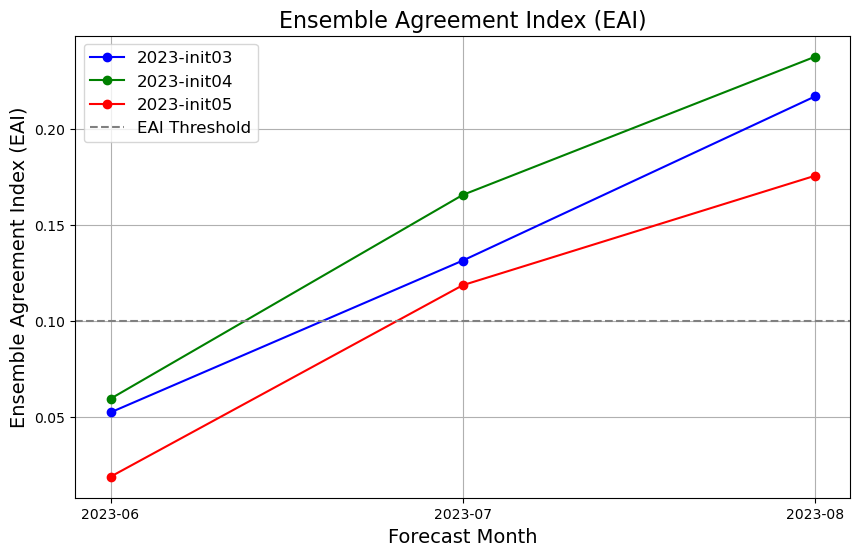

In [40]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Call the corrected EAI plotting function
plot_eai_line(
    ax=ax,
    forecast_years=[2023],
    init_months=["03", "04", "05"],      # List of initialization months
    forecast_months=["06", "07", "08"],  # Forecast-valid months (not used directly here)
    handler=handler,                     # Your configured handler object
    index_metric="TX30",                 # Climate index name
    threshold=5                          # Threshold for agreement detection
)

# Show the plot
plt.show()


In [44]:
# Re-import required packages after environment reset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def plot_smr_line(ax, forecast_years, init_months, handler, index_metric):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    color_idx = 0

    for year in forecast_years:
        for init_month in init_months:
            try:
                paths = handler.get_pipeline_path(year, init_month, "indices")
                monthly_path = paths.get("monthly")
                if not monthly_path or not monthly_path.exists():
                    print(f"Monthly file missing for {year}-init{init_month}.")
                    continue

                ds = xr.open_dataset(monthly_path)
                if index_metric not in ds:
                    print(f"Variable {index_metric} not found in {monthly_path}.")
                    continue

                da = ds[index_metric]
                aggregated = da.sum(dim=["latitude", "longitude"])
                steps = ds["step"].values

                smrs = []
                for step in steps:
                    group = aggregated.sel(step=step)
                    mean = group.mean(dim="number")
                    std = group.std(dim="number")
                    smrs.append((std / mean).values)

                ax.plot(steps, smrs, marker='o', linestyle='-',
                        color=colors[color_idx % len(colors)], label=f'{year}-init{init_month}')
                color_idx += 1

            except Exception as e:
                print(f"Error for {year}-init{init_month}: {e}")

    ax.axhline(y=1.0, color='gray', linestyle='--', label='SMR Threshold')
    ax.set_xlabel('Forecast Month', fontsize=14)
    ax.set_ylabel('Spread to Mean Ratio (SMR)', fontsize=14)
    ax.set_title('Spread to Mean Ratio (SMR)', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)

def plot_iqr_line(ax, forecast_years, init_months, handler, index_metric):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    color_idx = 0

    for year in forecast_years:
        for init_month in init_months:
            try:
                paths = handler.get_pipeline_path(year, init_month, "indices")
                monthly_path = paths.get("monthly")
                if not monthly_path or not monthly_path.exists():
                    print(f"Monthly file missing for {year}-init{init_month}.")
                    continue

                ds = xr.open_dataset(monthly_path)
                if index_metric not in ds:
                    print(f"Variable {index_metric} not found in {monthly_path}.")
                    continue

                da = ds[index_metric]
                aggregated = da.sum(dim=["latitude", "longitude"])
                steps = ds["step"].values

                iqrs = []
                for step in steps:
                    group = aggregated.sel(step=step)
                    q75 = group.quantile(0.75, dim="number")
                    q25 = group.quantile(0.25, dim="number")
                    iqrs.append((q75 - q25).values)

                ax.plot(steps, iqrs, marker='o', linestyle='-',
                        color=colors[color_idx % len(colors)], label=f'{year}-init{init_month}')
                color_idx += 1

            except Exception as e:
                print(f"Error for {year}-init{init_month}: {e}")

    ax.axhline(y=50, color='gray', linestyle='--', label='IQR Threshold')
    ax.set_xlabel('Forecast Month', fontsize=14)
    ax.set_ylabel('Interquartile Range (IQR)', fontsize=14)
    ax.set_title('Interquartile Range (IQR)', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)

def plot_ensemble_spread_line(ax, forecast_years, init_months, handler, index_metric):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    color_idx = 0

    for year in forecast_years:
        for init_month in init_months:
            try:
                paths = handler.get_pipeline_path(year, init_month, "indices")
                monthly_path = paths.get("monthly")
                if not monthly_path or not monthly_path.exists():
                    print(f"Monthly file missing for {year}-init{init_month}.")
                    continue

                ds = xr.open_dataset(monthly_path)
                if index_metric not in ds:
                    print(f"Variable {index_metric} not found in {monthly_path}.")
                    continue

                da = ds[index_metric]
                aggregated = da.sum(dim=["latitude", "longitude"])
                steps = ds["step"].values

                spreads = []
                for step in steps:
                    group = aggregated.sel(step=step)
                    spread = group.std(dim="number")
                    spreads.append(spread.values)

                ax.plot(steps, spreads, marker='o', linestyle='-',
                        color=colors[color_idx % len(colors)], label=f'{year}-init{init_month}')
                color_idx += 1

            except Exception as e:
                print(f"Error for {year}-init{init_month}: {e}")

    ax.axhline(y=100, color='gray', linestyle='--', label='Ensemble Spread Threshold')
    ax.set_xlabel('Forecast Month', fontsize=14)
    ax.set_ylabel('Ensemble Spread', fontsize=14)
    ax.set_title('Ensemble Spread', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)

def plot_eai_line(ax, forecast_years, init_months, forecast_months, handler, index_metric, threshold):
    import numpy as np
    import xarray as xr
    import matplotlib.pyplot as plt

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    color_idx = 0

    for year in forecast_years:
        for init_month in init_months:
            try:
                paths = handler.get_pipeline_path(year, init_month, "indices")

                monthly_path = paths.get("monthly")
                if not monthly_path or not monthly_path.exists():
                    print(f"Monthly file missing for {year}-init{init_month}.")
                    continue

                ds = xr.open_dataset(monthly_path)

                if index_metric not in ds:
                    print(f"Variable {index_metric} not found in {monthly_path}.")
                    continue

                above_thresh = ds[index_metric] > threshold
                eai = above_thresh.sum(dim="number") / above_thresh.sizes["number"]
                eai_avg = eai.mean(dim=["latitude", "longitude"])
                forecast_steps = ds["step"].values

                ax.plot(
                    forecast_steps,
                    eai_avg.values,
                    marker='o',
                    linestyle='-',
                    color=colors[color_idx % len(colors)],
                    label=f"{year}-init{init_month}"
                )
                color_idx += 1

            except Exception as e:
                print(f"Error for {year}-init{init_month}: {e}")

    ax.axhline(y=0.1, color='gray', linestyle='--', label='EAI Threshold')
    ax.set_xlabel("Forecast Month", fontsize=14)
    ax.set_ylabel("Ensemble Agreement Index (EAI)", fontsize=14)
    ax.set_title("Ensemble Agreement Index (EAI)", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)
    
def forecast_skills_metrics(forecast_years, init_months, handler, index_metric, threshold):
    """
    Plot all forecast skill metrics in a 2x2 layout.

    Parameters
    ----------
    forecast_years : list of int
        Years for which the forecasts were generated.
    init_months : list of str
        List of initialization months as strings (e.g., ['03', '04', '05']).
    handler : object
        Object with get_pipeline_path(...) method.
    index_metric : str
        Name of the index to be evaluated (e.g., 'TX30').
    threshold : float
        Threshold for EAI computation.

    Returns
    -------
    None
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle("Ensemble Skill Metrics", fontsize=16)

    plot_smr_line(axes[0, 0], forecast_years, init_months, handler, index_metric)
    plot_iqr_line(axes[0, 1], forecast_years, init_months, handler, index_metric)
    plot_ensemble_spread_line(axes[1, 0], forecast_years, init_months, handler, index_metric)
    plot_eai_line(axes[1, 1], forecast_years, init_months, forecast_months=None, handler=handler, index_metric=index_metric, threshold=threshold)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.figtext(0.02, -0.05, "The first month in each plot represents the initialization. "
                             "Subsequent months are forecast-valid months based on the index 'step' coordinate.",
                wrap=True, fontsize=14)

    plt.figtext(0.02, -0.10, "SMR (Spread to Mean Ratio): Measures variability relative to the mean. "
                             "Higher SMR implies greater uncertainty. Threshold line: SMR = 1.",
                wrap=True, fontsize=14)

    plt.figtext(0.02, -0.15, "IQR (Interquartile Range): Difference between Q3 and Q1 across ensemble members. "
                             "Larger IQR signals higher spread. Threshold line: IQR = 50.",
                wrap=True, fontsize=14)

    plt.figtext(0.02, -0.20, "Ensemble Spread: Standard deviation among ensemble members. "
                             "High values indicate more disagreement. Threshold line: 100.",
                wrap=True, fontsize=14)

    plt.figtext(0.02, -0.25, "EAI (Ensemble Agreement Index): Proportion of members above threshold. "
                             "High EAI implies strong forecast agreement. Threshold line: 0.1.",
                wrap=True, fontsize=14)

    plt.show()




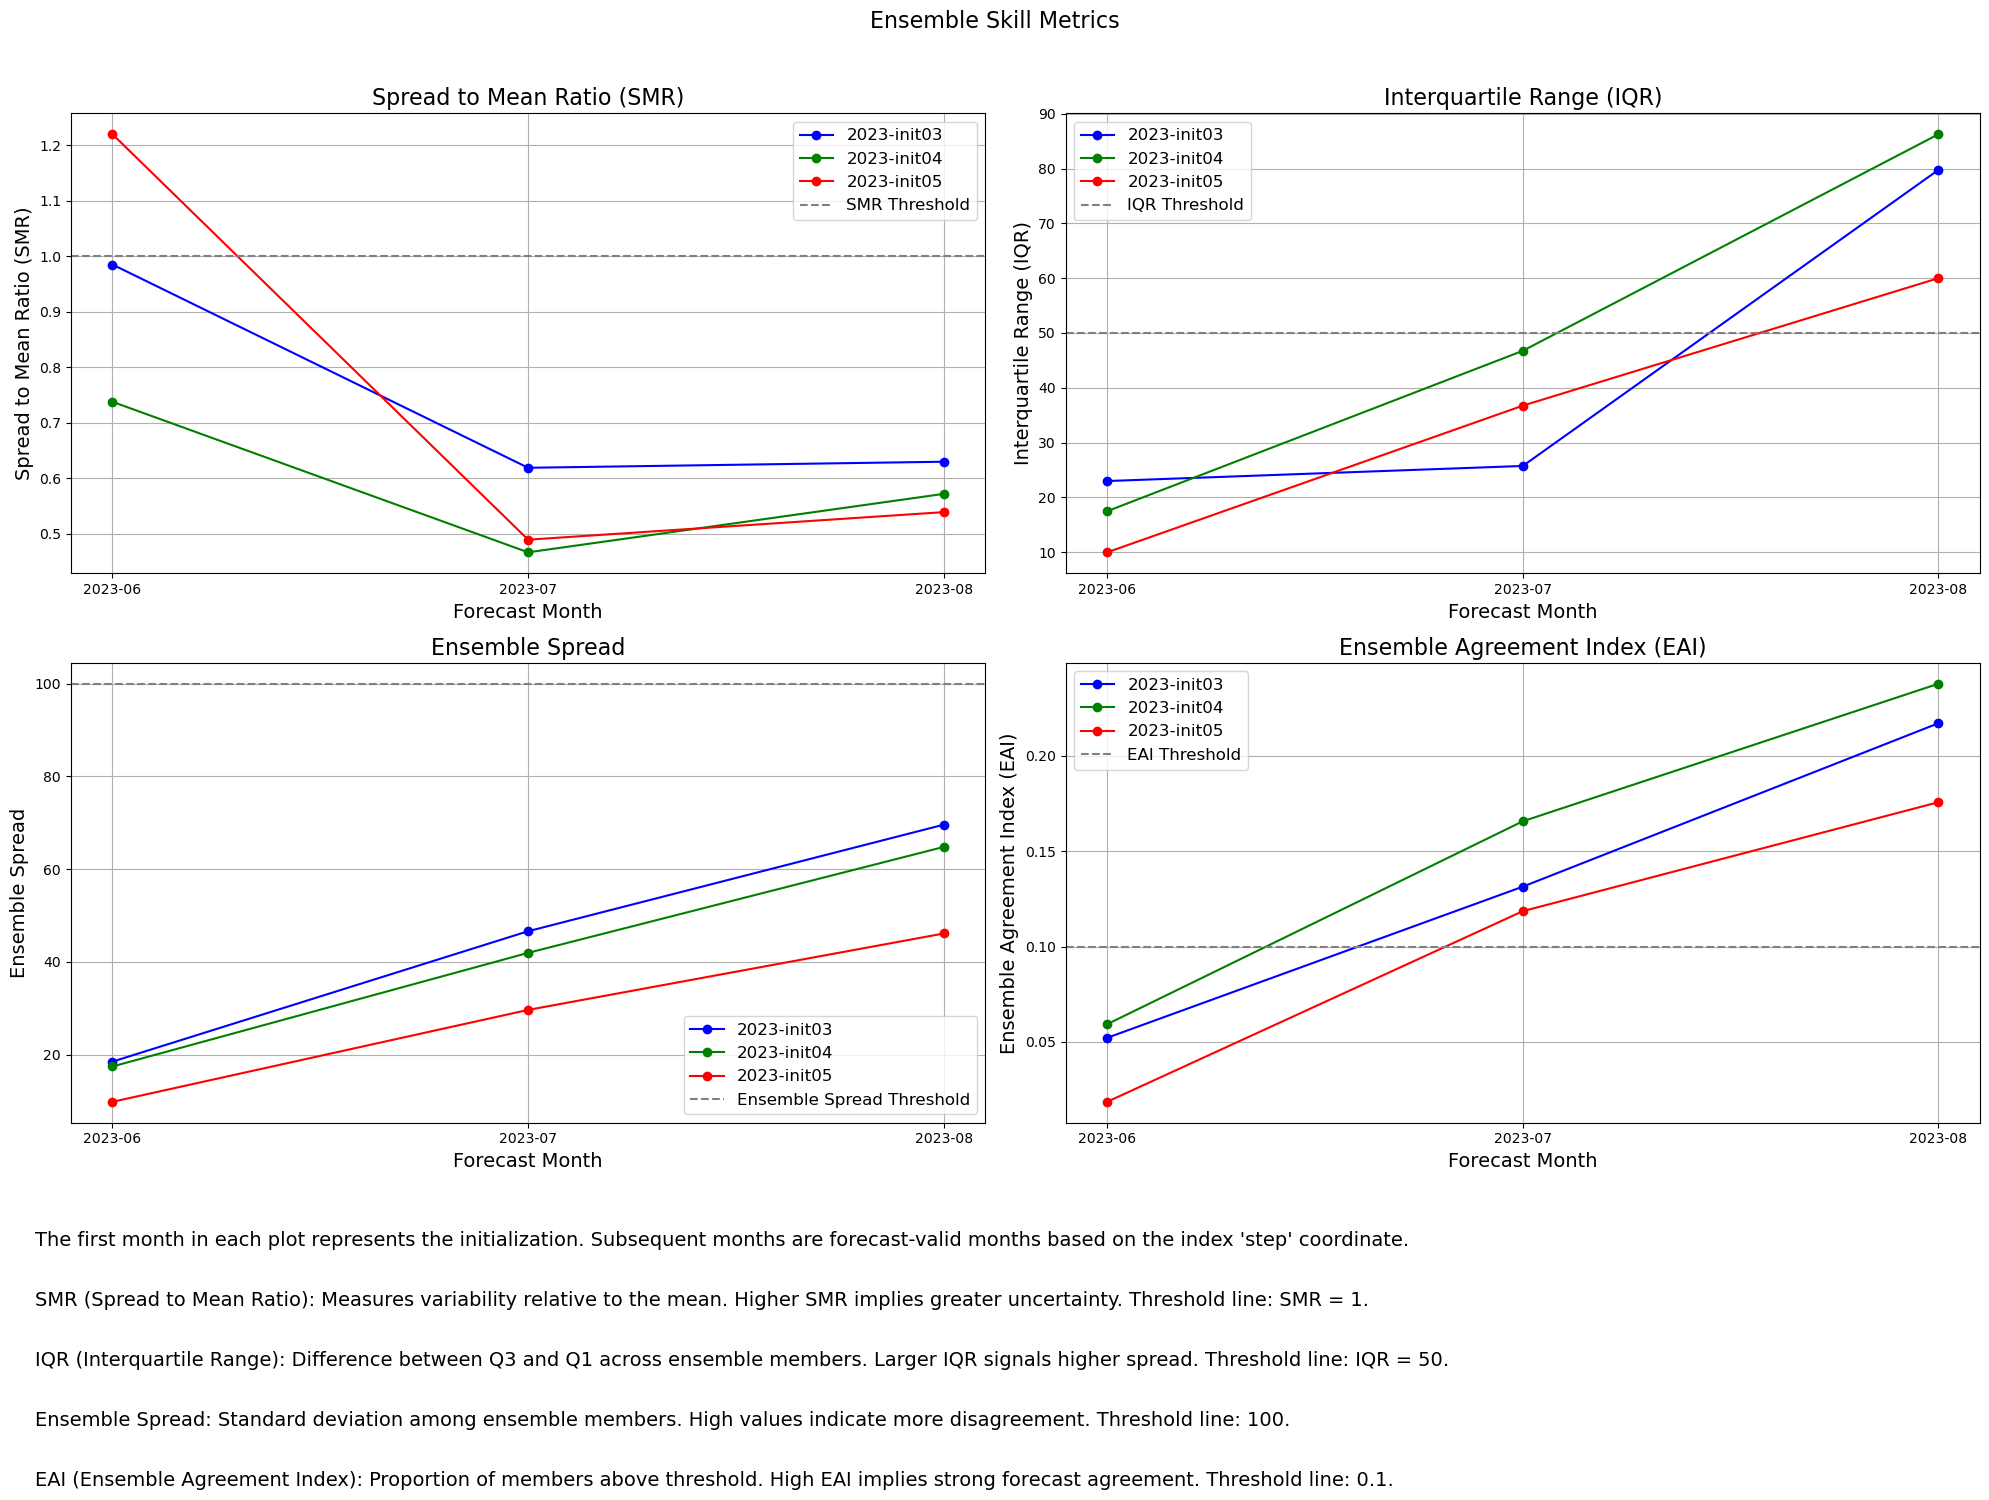

In [45]:
# Example usage
forecast_years = [2023]
init_months = ["03", "04", "05"]
index_metric = "TX30"
threshold = 5  # Example threshold for EAI

forecast_skills_metrics(
    forecast_years=forecast_years,
    init_months=init_months,
    handler=handler,
    index_metric=index_metric,
    threshold=threshold
)
